In [1]:
from pathlib import Path
import numpy as np
import h5py
from tqdm.auto import tqdm, trange
import scipy.io
import time
import torch
import random
import math
import shutil
from sklearn.decomposition import PCA
import scipy as sp
import scipy.signal

In [2]:
import matplotlib.pyplot as plt
# %matplotlib inline
plt.rc("figure", dpi=100)
SMALL_SIZE = 8
MEDIUM_SIZE = 10
BIGGER_SIZE = 12
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE)
plt.rc('axes', labelsize=SMALL_SIZE)
plt.rc('xtick', labelsize=SMALL_SIZE)
plt.rc('ytick', labelsize=SMALL_SIZE)
plt.rc('legend', fontsize=SMALL_SIZE)
plt.rc('figure', titlesize=BIGGER_SIZE)

## Load Data

In [3]:
nyu_templates_path = '/Users/ankit/Documents/PaninskiLab/nyu47_templates/'
dy_templates_path = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
temp_file = 'kilosort_cleaned_templates.npy'
good_unit_file = 'good_units_kilosort.npy'

kilo_temps = np.load(dy_templates_path + temp_file)
good_units = np.load(dy_templates_path + good_unit_file)
kilo_good = kilo_temps[good_units]
# bad_templates = np.array([207, 145, 99, 6, 141, 142, 220, 146, 178, 302, 177, 200, 139, 191, 181, 157, 182, 254])
# kilo_temps = np.delete(kilo_temps, bad_templates, axis=0)

print(kilo_temps.shape)
print(good_units.shape)
print(good_units)

(482, 121, 384)
(0,)
[]


In [4]:
mcs = np.array([np.abs(wf).max(0).argmax() for wf in kilo_temps])
align_ts = np.asarray([np.abs(wf[:, mc]).argmax() for (wf, mc) in zip(kilo_temps, mcs)])

In [6]:
unit_max_channels = np.array([np.argmax(np.max(template, axis=0) - np.min(template, axis=0)) for template in kilo_temps])
max_peak_inds = np.array([np.argmax(template, axis=0) for template in kilo_temps])
max_chan_templates = np.array([kilo_temps[i].T[unit_max_channels[i]] for i in range(len(unit_max_channels))])

In [7]:
ptps = np.array([np.max(template.max(0) - template.min(0)) for template in kilo_temps])
high_ptp_indices = np.array([i for i in range(len(kilo_temps)) if ptps[i] > 5])
high_ptp_temps = kilo_temps[high_ptp_indices]
max_chan_hptp_temps = max_chan_templates[high_ptp_indices]

# Model and Data Augmentation Definition in Pytorch

In [11]:
from __future__ import print_function, division
from array import array
import os
import math
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torch.distributions.uniform import Uniform
from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.bernoulli import Bernoulli
# from torchaudio.transforms import Resample

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode


# class AmpJitter(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """
#     def __init__(self, lo=0.9, hi=1.1):
#         self.lo = lo
#         self.hi = hi

#     def __call__(self, sample):
#         wf = sample
        
#         amp_jit = np.random.uniform(self.lo, self.hi)
#         wf = amp_jit * wf
    
#         return wf

class AmpJitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __init__(self, lo=0.9, hi=1.1):
        self.lo = lo
        self.hi = hi

    def __call__(self, sample):
        wf = sample
        if len(wf.shape) == 1:
            wf = np.expand_dims(wf, axis=0)
        n_chans = wf.shape[0]
        
        amp_jit = np.random.uniform(self.lo, self.hi, n_chans)

        wf = wf * amp_jit[:, None]
        # for i in range(n_chans):
        #     amp_jit = np.random.uniform(self.lo, self.hi)
        #     wf[i] = amp_jit * wf[i]
    
        return wf

class GaussianNoise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]
        
        noise_wf = np.random.normal(0, 1, w)
        wf = np.add(wf, noise_wf)

        return wf

# class SmartNoise(object):
#     """Rescale the image in a sample to a given size.

#     Args:
#         output_size (tuple or int): Desired output size. If tuple, output is
#             matched to output_size. If int, smaller of image edges is matched
#             to output_size keeping aspect ratio the same.
#     """
#     root_folder = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
#     temporal_name = 'temporal_cov_example.npy'
#     spatial_name = 'spatial_cov_example.npy'

#     def __init__(self, root_folder=None, temporal_cov=None, spatial_cov=None):
#         if root_folder is not None:
#             self.root_folder = root_folder
#         if temporal_cov is None:
#             temporal_cov = np.load(os.path.join(self.root_folder, self.temporal_name))
#         if spatial_cov is None:
#             spatial_cov = np.load(os.path.join(self.root_folder, self.spatial_name))
#         self.temporal_cov = temporal_cov
#         self.spatial_cov = spatial_cov

#     def __call__(self, sample):
#         wf = sample
#         w = wf.shape[0]

#         assert self.temporal_cov.shape[0] == w

#         n_neigh, _ = self.spatial_cov.shape
#         waveform_length, _ = self.temporal_cov.shape

#         noise = np.random.normal(size=(waveform_length, n_neigh))

#         noise = np.matmul(noise.T, self.temporal_cov).T
#         reshaped_noise = np.reshape(noise, (-1, n_neigh))

#         the_noise = np.reshape(np.matmul(reshaped_noise, self.spatial_cov),
#                            (waveform_length, n_neigh))

#         noise_sel = np.random.choice(n_neigh)
#         noise_wf = the_noise[:, noise_sel]
#         wf = np.add(wf, noise_wf)

#         return wf

class SmartNoise(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
    temporal_name = 'temporal_cov_example.npy'
    spatial_name = 'spatial_cov_example.npy'

    def __init__(self, root_folder=None, temporal_cov=None, spatial_cov=None, noise_scale=1.0):
        if root_folder is not None:
            self.root_folder = root_folder
        if temporal_cov is None:
            temporal_cov = np.load(os.path.join(self.root_folder, self.temporal_name))
        if spatial_cov is None:
            spatial_cov = np.load(os.path.join(self.root_folder + self.spatial_name))
        self.temporal_cov = temporal_cov
        self.spatial_cov = spatial_cov
        # self.noise_scale = np.float64(noise_scale)
        self.noise_scale = np.float32(noise_scale)
        

    def __call__(self, sample):
        wf = sample
        if len(wf.shape) == 1:
            wf = np.expand_dims(wf, axis=0)
        n_chans = wf.shape[0]
        w = wf.shape[1]

        assert self.temporal_cov.shape[0] == w

        n_neigh, _ = self.spatial_cov.shape
        waveform_length, _ = self.temporal_cov.shape

        noise = np.random.normal(size=(waveform_length, n_neigh))

        noise = np.matmul(noise.T, self.temporal_cov).T
        reshaped_noise = np.reshape(noise, (-1, n_neigh))

        the_noise = np.reshape(np.matmul(reshaped_noise, self.spatial_cov),
                        (waveform_length, n_neigh))

        noise_sel = np.random.choice(n_neigh, n_chans, replace=False)
        noise_wfs = self.noise_scale * the_noise[:, noise_sel].T
        wf = wf + noise_wfs

        # for i in range(n_chans):
        #     noise_wf = the_noise[:, noise_sel[i]]
        #     noise_wf = self.noise_scale * noise_wf
        #     wf[i] = np.add(wf[i], noise_wf)

        return wf

class Collide(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
    temp_name = 'spikes_train.npy'

    def __init__(self, root_folder=None, templates=None):
        if root_folder is not None:
            self.root_folder = root_folder
        if templates is None:
            templates = np.load(os.path.join(self.root_folder, self.temp_name))
        # assert isinstance(templates, (array, array))
        self.templates = templates

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]

        temp_idx = np.random.randint(0, len(self.templates))
        temp_sel = self.templates[temp_idx]
        
        scale = np.random.uniform(0.2, 1)
        shift = (2* np.random.binomial(1, 0.5)-1) * np.random.randint(5, 60)

        temp_sel = temp_sel * scale
        temp_sel = self.shift_chans(temp_sel, shift)

        wf = wf + temp_sel

        return wf, temp_sel

    def shift_chans(self, wf, shift_):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf, (0, int_shift), 'constant') 
        curr_wf_neg = np.pad(wf, (int_shift, 0), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=0)[:-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=0)[int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=0)*(shift_-floor))[:-ceil] + (np.roll(curr_wf_pos,floor, axis=0)*(ceil-shift_))[:-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=0)*(shift_-floor))[-floor:] + (np.roll(curr_wf_neg,floor, axis=0)*(ceil-shift_))[-floor:]
        wf_final = temp

        return wf_final


class Jitter(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, templates=None, up_factor=8, sample_rate=20000, shift=2):
        assert isinstance(up_factor, (int))
        assert isinstance(sample_rate, (int))
        self.templates = templates
        self.up_factor = up_factor
        self.sample_rate = sample_rate
        self.shift = shift

    def __call__(self, sample):
        wf = sample
        if len(wf.shape) == 1:
            wf = np.expand_dims(wf, axis=0)
        n_chans = wf.shape[0]
        w = wf.shape[1]
        
        up_temp = sp.signal.resample(
            x=wf,
            num=w*self.up_factor,
            axis=1)
            
        idx = (np.arange(0, w)[:,None]*self.up_factor + np.arange(self.up_factor))
        up_shifted_temp = np.transpose(up_temp[:, idx], (0, 2, 1))

        # temp_idx = np.random.choice(0, len(self.templates))
        # temp_sel = self.templates[temp_idx]

        # idx = np.arange(0, self.up_factor*w).reshape(-1, self.up_factor)
        # up_shifted_wfs = wf_upsamp[idx]
        # up_shifted_temps.unsqueeze(1)
        # up_shifted_temps = torch.cat(
        #     (up_shifted_temps,temp_sel),
        #     axis=1)
        

        shift = (2* np.random.binomial(1, 0.5)-1) * np.random.uniform(0, self.shift)
        
        idx_selection = np.random.choice(self.up_factor, n_chans)
        wf = up_shifted_temp[np.arange(n_chans), idx_selection]
        wf = self.shift_chans(wf, shift)

        return wf

    def shift_chans(self, wf, shift_):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf, ((0, 0), (0, int_shift)), 'constant') 
        curr_wf_neg = np.pad(wf, ((0, 0), (int_shift, 0)), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=1)[:, :-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=1)[:, int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=1)*(shift_-floor))[:, :-ceil] + (np.roll(curr_wf_pos,floor, axis=1)*(ceil-shift_))[:, :-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=1)*(shift_-floor))[:, -floor:] + (np.roll(curr_wf_neg,floor, axis=1)*(ceil-shift_))[:, -floor:]
        wf_final = temp

        return wf_final
    
class MaxChanShift(object):
    def __init__(self, prob=0.5):
        self.prob = prob
        
    def __call__(self, wf):
        n_chan, n_times = wf.shape
        max_chan_ind = math.floor(n_chan/2)
        num_extra_chans = math.floor(max_chan_ind/2)

        apply = np.random.binomial(1, self.prob)
        if apply:
            shift = np.random.randint(-num_extra_chans, num_extra_chans+1)
            max_chan_ind += shift

        wf = wf[max_chan_ind-num_extra_chans:max_chan_ind+num_extra_chans+1]
        return wf

class MultiChanCollide(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
    mc_wfs_path = 'multichan_spikes_train.npy'

    def __init__(self, root_folder=None, mc_wfs=None):
        if root_folder is not None:
            self.root_folder = root_folder
        if mc_wfs is None:
            mc_wfs = np.load(os.path.join(self.root_folder, self.mc_wfs_path))
        # assert isinstance(templates, (array, array))
        self.mc_wfs = mc_wfs

    def __call__(self, wf):
        n_wfs, n_chan, n_times = self.mc_wfs.shape
        rand_ind = np.random.choice(n_wfs)
        rand_wf = self.mc_wfs[rand_ind]

        scale = np.random.uniform(0.2, 1)
        shift = (2 * np.random.binomial(1, 0.5)-1) * np.random.randint(5, 60)
        
        rand_wf *= scale
        rand_wf = self.shift_chans(rand_wf, shift)

        wf = wf + rand_wf

        return wf, rand_wf

    def shift_chans(self, wf, shift_):
        # use template feat_channel shifts to interpolate shift of all spikes on all other chans
        int_shift = int(math.ceil(shift_)) if shift_ >= 0 else -int(math.floor(shift_))
        curr_wf_pos = np.pad(wf, ((0, 0), (0, int_shift)), 'constant') 
        curr_wf_neg = np.pad(wf, ((0, 0), (int_shift, 0)), 'constant')
        if int(shift_)==shift_:
            ceil = int(shift_)
            temp = np.roll(curr_wf_pos,ceil,axis=1)[:, :-int_shift] if shift_ > 0 else np.roll(curr_wf_neg,ceil,axis=1)[:, int_shift:]
        else:
            ceil = int(math.ceil(shift_))
            floor = int(math.floor(shift_))
            if shift_ > 0:
                temp = (np.roll(curr_wf_pos,ceil,axis=1)*(shift_-floor))[:-ceil] + (np.roll(curr_wf_pos,floor, axis=1)*(ceil-shift_))[:-ceil]
            else:
                temp = (np.roll(curr_wf_neg,ceil,axis=1)*(shift_-floor))[-floor:] + (np.roll(curr_wf_neg,floor, axis=1)*(ceil-shift_))[-floor:]
        wf_final = temp

        return wf_final
    
    
class ElectrodeDropout(object):
    def __init__(self, prob=0.1):
        self.p_drop_chan = prob
        
    def __call__(self, wf):
        n_chan, n_times = wf.shape
        chan_mask = -1 * np.random.binomial(1, self.p_drop_chan, n_chan) + 1
        print(chan_mask)
        
        wf[chan_mask == 0] = np.zeros(n_times)

        return wf
    
class PCA_Reproj(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """
    root_folder = '/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/'
    temp_name = 'spikes_train.npy'

    def __init__(self, spikes=None, pca_dim=5):
        assert isinstance(pca_dim, (int))
        if spikes is None:
            spikes = np.load(os.path.join(self.root_folder, self.temp_name))
        self.spikes = spikes
        self.pca_ = PCA(n_components=pca_dim).fit(self.spikes)
        self.spikes_mean = np.mean(self.spikes, axis=0)

    def __call__(self, sample):
        wf = sample
        w = wf.shape[0]
        
        transform = self.pca_.transform(sample.reshape(1, -1))
        recon = self.pca_.inverse_transform(transform)[0]

        return recon

    
class ToWfTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        wf = sample
        
        return torch.from_numpy(wf)



In [12]:
from fileinput import filename
import torch
import numpy as np

from torchvision.transforms import transforms
from torchvision import transforms, datasets
from torch.utils.data import Dataset
from typing import Any, Callable, Optional, Tuple

np.random.seed(0)

class BaseSimCLRException(Exception):
    """Base exception"""


class InvalidBackboneError(BaseSimCLRException):
    """Raised when the choice of backbone Convnet is invalid."""


class InvalidDatasetSelection(BaseSimCLRException):
    """Raised when the choice of dataset is invalid."""


class ContrastiveLearningViewGenerator(object):
    """Take two random crops of one image as the query and key."""

    def __init__(self, base_transform, n_views=2):
        self.base_transform = base_transform
        self.n_views = n_views

    def __call__(self, x):
        return [self.base_transform(x) for i in range(self.n_views)]


class WFDataset(Dataset):
    filename = "kilo_hptp_mcs.npy"

    def __init__(
        self,
        root: str,
        transform: Optional[Callable] = None
    ) -> None:

        super().__init__()

        self.data: Any = []

        # now load the numpy array
        self.data = np.load(root + self.filename)
        self.root = root
        self.transform = transform

    def __getitem__(self, index: int) -> Any :
        """
        Args:
            index (int): Index

        Returns:
            tensor: wf
        """
        wf = self.data[index]

        # doing this so that it is a tensor
        # wf = torch.from_numpy(wf)

        if self.transform is not None:
            wf = self.transform(wf)

        return wf


    def __len__(self) -> int:
        return len(self.data)


class ContrastiveLearningDataset:
    def __init__(self, root_folder):
        self.root_folder = root_folder
    

    # @staticmethod
    # def get_simclr_pipeline_transform(size, s=1):
    #     """Return a set of data augmentation transformations as described in the SimCLR paper."""
    #     color_jitter = transforms.ColorJitter(0.8 * s, 0.8 * s, 0.8 * s, 0.2 * s)
    #     data_transforms = transforms.Compose([transforms.RandomResizedCrop(size=size),
    #                                           transforms.RandomHorizontalFlip(),
    #                                           transforms.RandomApply([color_jitter], p=0.8),
    #                                           transforms.RandomGrayscale(p=0.2),
    #                                           GaussianBlur(kernel_size=int(0.1 * size)),
    #                                           transforms.ToTensor()])
    #     return data_transforms
    
    @staticmethod
    def get_wf_pipeline_transform(self, temp_cov_fn, probs):
        temporal_cov = np.load(self.root_folder + temp_cov_fn)
        if probs is None:
            probs = [0.7, 0.6, 0.5, 0.3]
        """Return a set of data augmentation transformations on waveforms."""
        data_transforms = transforms.Compose([transforms.RandomApply([AmpJitter()], p=probs[0]),
                                              transforms.RandomApply([Jitter()], p=probs[1]),
                                              transforms.RandomApply([SmartNoise(temporal_cov)], p=probs[2]),
                                              transforms.RandomApply([Collide()], p=probs[3]),
                                              ToWfTensor()])
        
        return data_transforms

    def get_dataset(self, name, n_views, probs=None):
        temp_cov_fn = 'temporal_cov_example.npy'
        valid_datasets = {'wfs': lambda: WFDataset(self.root_folder,
                                                              transform=ContrastiveLearningViewGenerator(
                                                                  self.get_wf_pipeline_transform(self, temp_cov_fn, probs),
                                                                  n_views)),
                          'cifar10': lambda: datasets.CIFAR10(self.root_folder, train=True,
                                                              transform=ContrastiveLearningViewGenerator(
                                                                  self.get_simclr_pipeline_transform(32),
                                                                  n_views),
                                                              download=True),

                          'stl10': lambda: datasets.STL10(self.root_folder, split='unlabeled',
                                                          transform=ContrastiveLearningViewGenerator(
                                                              self.get_simclr_pipeline_transform(96),
                                                              n_views),
                                                          download=True)}

        try:
            dataset_fn = valid_datasets[name]
        except KeyError:
            raise InvalidDatasetSelection()
        else:
            return dataset_fn()

## Loading dataset and augmenting 

In [35]:
ds = ContrastiveLearningDataset('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/')

In [26]:
dy_wfs = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/kilosort_cleaned_templates.npy')
unit_ids = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/unit_ids.npy')

In [27]:
print(dy_wfs.shape)
print(mcs.shape)

dy_wfs = np.transpose(dy_wfs, (0, 2, 1))[np.arange(dy_wfs.shape[0]), mcs]
print(dy_wfs.shape)

dy_wfs_sel = dy_wfs[unit_ids]
print(dy_wfs_sel.shape)

(482, 121, 384)
(482,)
(482, 121)
(118, 121)


In [37]:
wf_interest_dy = [2, 9, 11, 118, 57, 266, 339, 367, 373, 358]

In [28]:
wf_interest_dy = [8, 9, 11, 33, 65, 69, 109, 13, 329, 151]
wf_dy_idx = [0, 1, 2, 10, 22, 25, 38, 3, 50, 102]

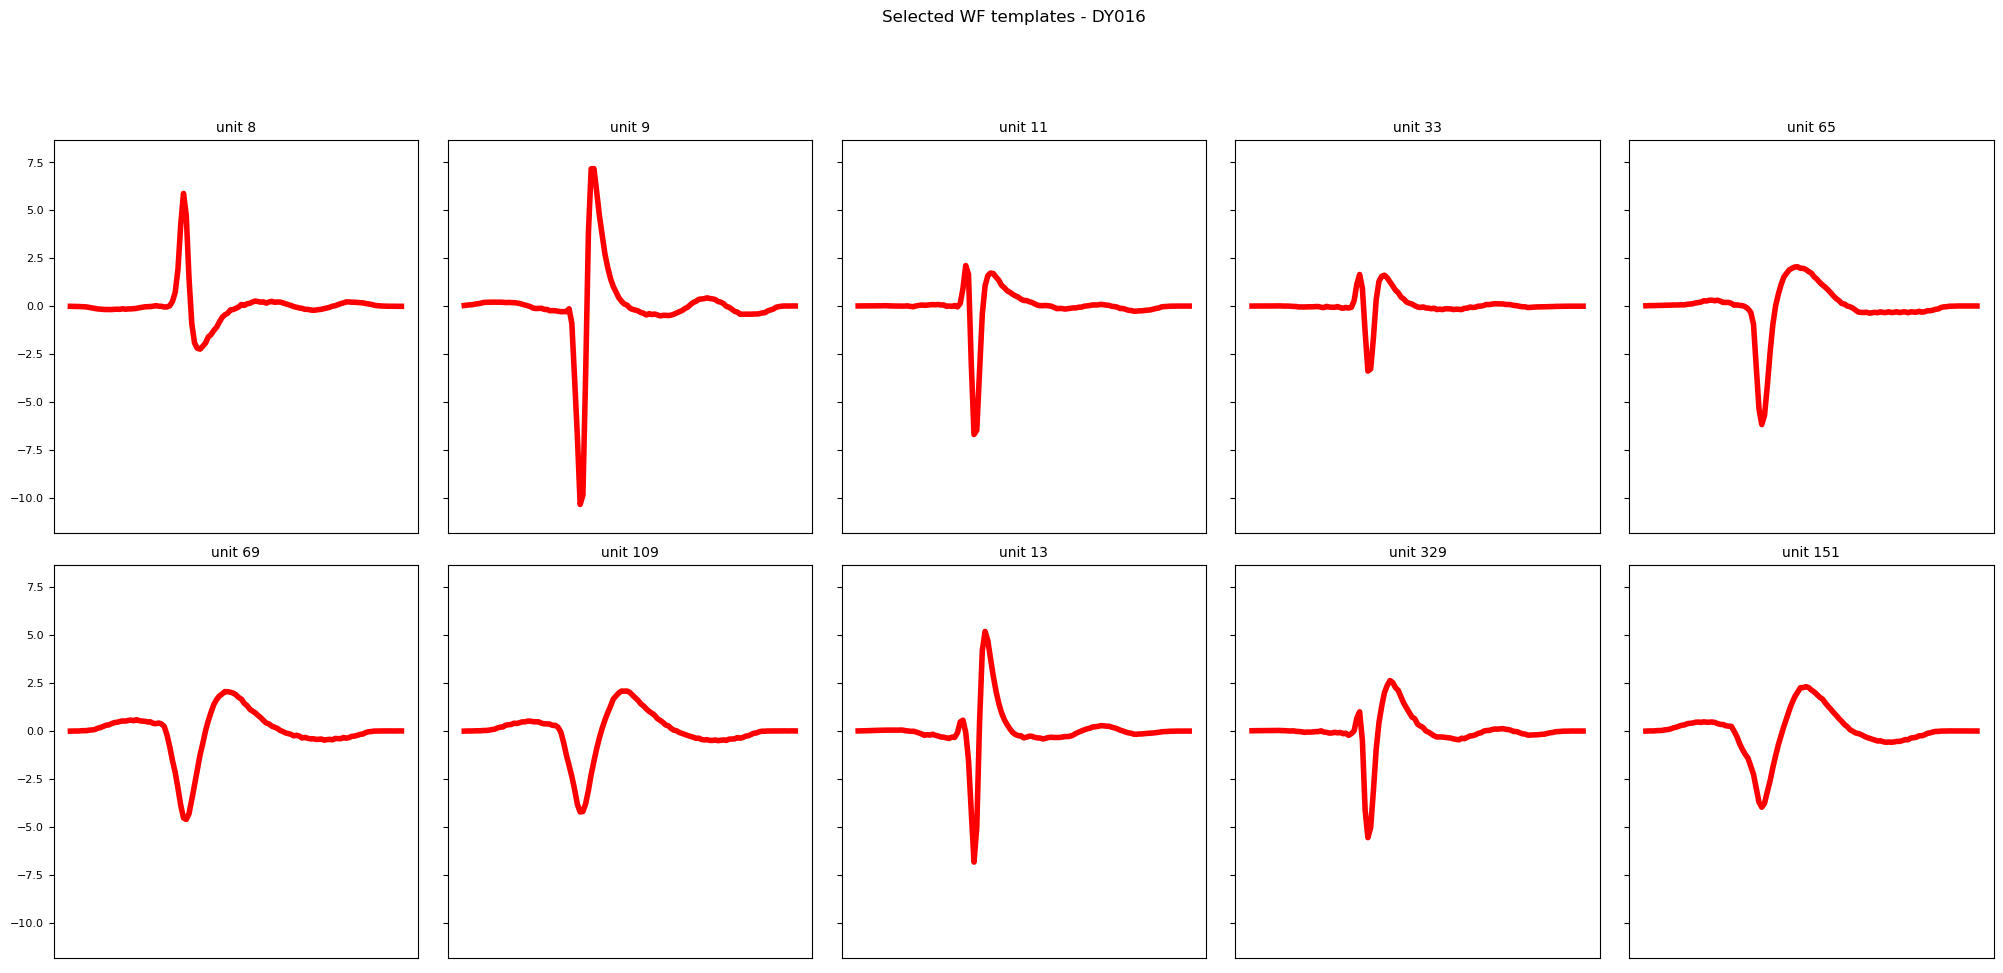

In [40]:
fig, ax = plt.subplots(2, 5, sharey='row', figsize=(20, 10))

fig.suptitle('Selected WF templates - DY016')
plt.tight_layout()
# st.set_y(0.95)
fig.subplots_adjust(top=0.85)
# max_chan_max = np.max(np.max(nyu_wfs, axis=1))
# max_chan_min = np.min(np.min(nyu_wfs, axis=1))
x = np.arange(0, 121)
for i in range(2):
    max_chan_max = np.max(np.max(dy_wfs[wf_interest_dy]+1, axis=1))
    max_chan_min = np.min(np.min(dy_wfs[wf_interest_dy]-1, axis=1))
    for j in range(5):
        idx = wf_interest_dy[5*i + j]
        ax[i, j].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        ax[i, j].get_xaxis().set_visible(False)
        ax[i, j].title.set_text('unit ' + str(idx))
        ax[i, j].plot(x, dy_wfs[idx], linewidth=4, markersize=12, color='red')
    
# plt.savefig('dy016_wfs')

In [39]:
full_dy_spikes = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/full_raw_spikes.npy', allow_pickle=True)
print(full_dy_spikes.shape)

(118,)


In [42]:
full_dy_mc_spikes = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/multichan_full_raw_spikes.npy', allow_pickle=True)
print(full_dy_mc_spikes.shape)

(10, 1500, 11, 121)


In [13]:
dy_mc_wfs_interest = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/multichan_spikes_train.npy')
dy_mc_wfs_test = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/multichan_spikes_test.npy')

print(dy_mc_wfs_interest.shape)
print(dy_mc_wfs_test.shape)

(12000, 11, 121)
(3000, 11, 121)


In [14]:
dy_wfs_interest = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/spikes_train.npy')
dy_wfs_test = np.load('/Users/ankit/Documents/PaninskiLab/contrastive_spikes/DY016/spikes_test.npy')

In [364]:
dy_denoised_wfs_train = []
dy_denoised_wfs_test = []

denoiser = SingleChanDenoiser()
denoiser.load('./../pretrained/single_chan_denoiser.pt')

for i in range(len(dy_wfs_interest)):
    curr_wf = dy_wfs_interest[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
#         print(den_wf.squeeze().numpy().shape)
        dy_denoised_wfs_train.append(den_wf.squeeze().numpy())

dy_denoised_wfs_train = np.array(dy_denoised_wfs_train)
print(dy_denoised_wfs_train.shape)
    
for i in range(len(dy_wfs_test)):
    curr_wf = dy_wfs_test[i]
    with torch.no_grad():
        curr_wf = torch.unsqueeze(torch.from_numpy(curr_wf), dim=0)
        den_wf = denoiser(curr_wf)
        dy_denoised_wfs_test.append(den_wf.squeeze().numpy())
    
dy_denoised_wfs_test = np.array(dy_denoised_wfs_test)

(12000, 121)


In [365]:
dy_denoised_mc_wfs_train = []
dy_denoised_mc_wfs_test = []

denoiser = SingleChanDenoiser()
denoiser.load('./../pretrained/single_chan_denoiser.pt')

for i in range(len(dy_mc_wfs_interest)):
    curr_wf = dy_mc_wfs_interest[i]
    den_wf = np.zeros(curr_wf.shape)
    with torch.no_grad():
        curr_wf = torch.from_numpy(curr_wf)
        den_wf = denoiser(curr_wf)
        dy_denoised_mc_wfs_train.append(den_wf.numpy())
#     dy_denoised_mc_wfs_train.append(den_wf)
    
dy_denoised_mc_wfs_train = np.array(dy_denoised_mc_wfs_train)

for i in range(len(dy_mc_wfs_test)):
    curr_wf = dy_mc_wfs_test[i]
    den_wf = np.zeros(curr_wf.shape)
    with torch.no_grad():
        curr_wf = torch.from_numpy(curr_wf)
        den_wf = denoiser(curr_wf)
        dy_denoised_mc_wfs_test.append(den_wf.numpy())
    
dy_denoised_mc_wfs_test = np.array(dy_denoised_mc_wfs_test)

In [15]:
import umap.umap_ as umap
from sklearn.decomposition import PCA

def learn_manifold_umap(data, umap_dim, umap_min_dist=0.2, umap_metric='euclidean', umap_neighbors=10):
    md = float(umap_min_dist)
    return umap.UMAP(random_state=0, metric=umap_metric, n_components=umap_dim, n_neighbors=umap_neighbors,
                    min_dist=md).fit_transform(data)

def pca_train(train, test, n_comps):
    pca_ = PCA(n_components=n_comps, whiten=True)
    pca_.fit(train)
    print('train done')
    test_comps = pca_.transform(test)
    print('pca test done')
    return test_comps, pca_.explained_variance_ratio_

def pca(S, n_comps):
    pca_ = PCA(n_components=n_comps, whiten=True)
    return pca_.fit_transform(S), pca_.explained_variance_ratio_


In [16]:
import torch.nn as nn
from collections import OrderedDict
from matplotlib.gridspec import GridSpec
from torch.nn import TransformerEncoder, TransformerEncoderLayer

# Model definition
# class SingleChanDenoiser(nn.Module):
#     """Cleaned up a little. Why is conv3 here and commented out in forward?"""

#     def __init__(
#         self, n_filters=[16, 8, 4], filter_sizes=[5, 11, 21], spike_size=121, out_size=2
#     ):
#         super(SingleChanDenoiser, self).__init__()
#         feat1, feat2, feat3 = n_filters
#         size1, size2, size3 = filter_sizes
#         print(out_size)
#         self.conv1 = nn.Sequential(nn.Conv1d(1, feat1, size1), nn.ReLU())
#         self.conv2 = nn.Sequential(nn.Conv1d(feat1, feat2, size2), nn.ReLU())
#         self.conv3 = nn.Sequential(nn.Conv1d(feat2, feat3, size3), nn.ReLU())
#         n_input_feat = feat2 * (spike_size - size1 - size2 + 2)
#         self.fc = nn.Linear(n_input_feat, out_size)

#     def forward(self, x):
#         x = x[:, None]
#         x = self.conv1(x)
#         x = self.conv2(x)
#         # x = self.conv3(x)
#         x = x.view(x.shape[0], -1)
#         return self.fc(x)

#     def load(self, fname_model):
#         checkpoint = torch.load(fname_model, map_location="cpu")
#         state_dict = checkpoint["state_dict"]
#         new_state_dict = OrderedDict()
#         for key in state_dict:
#             if "backbone" in key and "fc" not in key:
#                 new_key = '.'.join(key.split('.')[1:])
#                 new_state_dict[new_key] = state_dict[key]
#         new_state_dict["fc.weight"] = state_dict["backbone.fc.2.weight"]
#         new_state_dict["fc.bias"] = state_dict["backbone.fc.2.bias"]
#         self.load_state_dict(new_state_dict)
#         return self

class SingleChanDenoiser(nn.Module):
    """Cleaned up a little. Why is conv3 here and commented out in forward?"""

    def __init__(
        # self, n_filters=[16, 8, 4], filter_sizes=[5, 11, 21], spike_size=121
        self, n_filters=[16, 8, 4], filter_sizes=[5, 11, 21], spike_size=121
    ):
        super(SingleChanDenoiser, self).__init__()
        self.conv1 = nn.Sequential(nn.Conv1d(1, n_filters[0], filter_sizes[0]), nn.ReLU())
        self.conv2 = nn.Sequential(nn.Conv1d(n_filters[0], n_filters[1], filter_sizes[1]), nn.ReLU())
#         if len(n_filters) > 2:
        self.conv3 = nn.Sequential(nn.Conv1d(n_filters[1], n_filters[2], filter_sizes[2]), nn.ReLU())
        n_input_feat = n_filters[1] * (spike_size - filter_sizes[0] - filter_sizes[1] + 2)
        self.out = nn.Linear(n_input_feat, spike_size)

    def forward(self, x):
        x = x[:, None]
        x = self.conv1(x)
        x = self.conv2(x)
        # x = self.conv3(x)
        x = x.view(x.shape[0], -1)
        return self.out(x)

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        self.load_state_dict(checkpoint)
        return self

    
class Encoder(nn.Module):
    def __init__(self, Lv=[200, 150, 100, 75], ks=[11, 21, 31], out_size=2, proj_dim=5):
        super(Encoder, self).__init__()
        self.proj_dim = out_size if out_size < proj_dim else proj_dim
        self.enc_block1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=Lv[0], kernel_size=ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[0]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[0], Lv[1], ks[1], padding=math.ceil((ks[1]-1)/2)),
            nn.BatchNorm1d(Lv[1]),
            nn.ReLU(),
            nn.MaxPool1d(4),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[1], Lv[2], ks[2], padding=math.ceil((ks[2]-1)/2)),
            nn.BatchNorm1d(Lv[2]),
            nn.ReLU(),
            nn.MaxPool1d(4)
        )
        self.avgpool1d = nn.AdaptiveAvgPool1d((1))

        self.fcpart = nn.Sequential(
            nn.Linear(Lv[2] * 1 * 1, Lv[3]),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(Lv[3], out_size),
            Projector(rep_dim=out_size, proj_dim=self.proj_dim)
            )
        self.Lv = Lv

    def forward(self, x):
        x = self.enc_block1d(x)
        x = self.avgpool1d(x)
        x = x.view(-1, self.Lv[2] * 1 * 1)
        x = self.fcpart(x)
        return x

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for key in state_dict:
            # if "backbone" in key and "fc" not in key:
            new_key = '.'.join(key.split('.')[1:])
            new_state_dict[new_key] = state_dict[key]
        self.load_state_dict(new_state_dict)
        return self
    

class Encoder2(nn.Module):
    def __init__(self, Lv=[64, 128, 256, 256, 256], ks=[11], out_size = 2, proj_dim=5, fc_depth=2):
        super(Encoder2, self).__init__()
        self.proj_dim = out_size if out_size < proj_dim else proj_dim
        self.enc_block1d = nn.Sequential(
            nn.Conv1d(in_channels=1, out_channels=Lv[0], kernel_size=ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[0]),
            nn.ReLU(),
            nn.MaxPool1d(2),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[0], Lv[1], ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[1]),
            nn.ReLU(),
            nn.MaxPool1d(4),
            # nn.Dropout(p=0.2),
            nn.Conv1d(Lv[1], Lv[2], ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[2]),
            nn.ReLU(),
            nn.MaxPool1d(4),
            nn.Conv1d(Lv[2], Lv[3], ks[0], padding=math.ceil((ks[0]-1)/2)),
            nn.BatchNorm1d(Lv[2]),
            nn.ReLU(),
        )
        self.avgpool1d = nn.AdaptiveAvgPool1d((1))
        list_layers = [nn.Linear(Lv[3] * 1 * 1, Lv[4]), nn.ReLU(inplace=True)]
        for _ in range(fc_depth-2):
            list_layers += [nn.Linear(Lv[4], Lv[4]), nn.ReLU(inplace=True)]
        list_layers += [nn.Linear(Lv[4], out_size), nn.ReLU(inplace=True)]
        list_layers += [Projector(rep_dim=out_size, proj_dim=self.proj_dim)]
        
        self.fcpart = nn.Sequential(*list_layers)
        
        # nn.Sequential(
        #     nn.Linear(Lv[2] * 1 * 1, Lv[3]),
        #     nn.ReLU(),
        #     # nn.Dropout(p=0.2),
        #     nn.Linear(Lv[3], out_size),
        #     )
        self.Lv = Lv
        # self.projector = Projector2(rep_dim=out_size, proj_dim=self.proj_dim)
    def forward(self, x):
        x = self.enc_block1d(x)
        # print(x.shape)
        x = self.avgpool1d(x)
        x = x.view(-1, self.Lv[2] * 1 * 1)
        x = self.fcpart(x)
        # x = self.projector(x)
        return x
    
    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for key in state_dict:
            # if "backbone" in key and "fc" not in key:
            new_key = '.'.join(key.split('.')[1:])
            new_state_dict[new_key] = state_dict[key]
        self.load_state_dict(new_state_dict)
        return self
    
    
class PositionalEncoding(nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Tensor, shape [seq_len, batch_size, embedding_dim]
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)

    
class AttentionEnc(nn.Module):
    def __init__(self, spike_size=121, n_channels=1, out_size=2, proj_dim=5, fc_depth=2, nlayers=9, nhead=8, dropout=0.1, expand_dim=16):
        super(AttentionEnc, self).__init__()
        self.spike_size = spike_size
        self.expand_dim = expand_dim
        self.proj_dim = out_size if out_size < proj_dim else proj_dim
        if expand_dim != 1:
            self.encoder = nn.Linear(n_channels, expand_dim)
        else:
            nhead = 1
        self.pos_encoder = PositionalEncoding(expand_dim, dropout, spike_size)
        encoder_layers = TransformerEncoderLayer(expand_dim, nhead, 512, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        list_layers = [nn.Linear(self.spike_size * expand_dim, 256), nn.ReLU(inplace=True)]
        for _ in range(fc_depth-2):
            list_layers += [nn.Linear(256, 256), nn.ReLU(inplace=True)]
        list_layers += [nn.Linear(256, out_size)]
        list_layers += [Projector(rep_dim=out_size, proj_dim=self.proj_dim)]
        
        self.fcpart = nn.Sequential(*list_layers)
        
        # self.fcpart = nn.Sequential(
        #     nn.Linear(self.spike_size * expand_dim, self.spike_size),
        #     nn.ReLU(),
        #     nn.Linear(self.spike_size, out_size),
            
        #     # nn.ReLU(),
        #     # nn.Dropout(p=0.2),
        #     # nn.Linear(5 * self.spike_size * expand_dim, out_size),
        #     Projector(rep_dim=out_size, proj_dim=self.proj_dim)
        # )

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.fcpart.bias.data.zero_()
        self.fpcart.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]
        Returns:
            output Tensor of shape [batch_size, proj_dim]
        """
        src = torch.transpose(src, 1, 2)
        if self.expand_dim != 1:
            src = self.encoder(src) * math.sqrt(self.expand_dim)
        src = self.pos_encoder(src)
        output = self.transformer_encoder(src, src_mask)
        output = output.view(-1, self.spike_size * self.expand_dim)
        output = self.fcpart(output)
        return output

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for key in state_dict:
            # if "backbone" in key and "fc" not in key:
            new_key = '.'.join(key.split('.')[1:])
            new_state_dict[new_key] = state_dict[key]
            if 'pos_encoder' in key:
                new_state_dict[new_key] = state_dict[key].transpose(1, 0)
        self.load_state_dict(new_state_dict)
        return self

class MultiChanAttentionEnc1(nn.Module):
    def __init__(self, spike_size=121, n_channels=11, out_size=2, proj_dim=5, fc_depth=2, nlayers=9, nhead=8, dropout=0.1, expand_dim=16, cls_head=None):
        super(MultiChanAttentionEnc1, self).__init__()
        self.spike_size = spike_size
        self.expand_dim = expand_dim
        self.n_channels = n_channels
        self.proj_dim = out_size if out_size < proj_dim else proj_dim
        if expand_dim != 1:
            self.encoder = nn.Linear(1, expand_dim)
        else:
            nhead = 1
        self.pos_encoder = PositionalEncoding(expand_dim, dropout, spike_size, num_chans=n_channels)
        encoder_layers = TransformerEncoderLayer(expand_dim, nhead, 512, batch_first=True)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.encoder_sum = nn.Linear(n_channels, 1)
        list_layers = [nn.Linear(self.spike_size * self.expand_dim, 256), nn.ReLU(inplace=True)]
        for _ in range(fc_depth-2):
            list_layers += [nn.Linear(256, 256), nn.ReLU(inplace=True)]
        list_layers += [nn.Linear(256, out_size)]
        if not cls_head:
            list_layers += [Projector(rep_dim=out_size, proj_dim=self.proj_dim)]
        else:
            print(f"using head = {cls_head}")
            if cls_head == 'linear':
                self.cls_head = nn.Linear(out_size, 10)
            elif cls_head == 'mlp2':
                self.cls_head = nn.Sequential(nn.Linear(out_size, 100), nn.ReLU(inplace=True), \
                    nn.Linear(100, 10))
            elif cls_head == 'mlp3':
                self.cls_head = nn.Sequential(nn.Linear(out_size, 100), nn.ReLU(inplace=True), \
                    nn.Linear(100, 50), nn.ReLU(inplace=True), \
                    nn.Linear(50, 10))
            list_layers += [self.cls_head]
            
        self.fcpart = nn.Sequential(*list_layers)
        
        # self.fcpart = nn.Sequential(
        #     nn.Linear(self.spike_size * expand_dim, self.spike_size),
        #     nn.ReLU(),
        #     nn.Linear(self.spike_size, out_size),
            
        #     # nn.ReLU(),
        #     # nn.Dropout(p=0.2),
        #     # nn.Linear(5 * self.spike_size * expand_dim, out_size),
        #     Projector(rep_dim=out_size, proj_dim=self.proj_dim)
        # )

    def init_weights(self) -> None:
        initrange = 0.1
        # self.encoder.weight.data.uniform_(-initrange, initrange)
        self.fcpart.bias.data.zero_()
        self.fpcart.weight.data.uniform_(-initrange, initrange)

    def forward(self, src, src_mask=None):
        """
        Args:
            src: Tensor, shape [batch_size, seq_len]
            src_mask: Tensor, shape [seq_len, seq_len]
        Returns:
            output Tensor of shape [batch_size, proj_dim]
        """
        # src = torch.transpose(src, 1, 2)

        # for chan in range(self.n_channels):
        #     curr_chan = src[:, :, chan]
        #     curr_chan = torch.unsqueeze(curr_chan, dim=2)
        #     # curr_chan = torch.transpose(curr_chan, 1, 2)
        #     if self.expand_dim != 1:
        #         curr_chan = self.encoder(curr_chan) * math.sqrt(self.expand_dim)
        #     curr_chan = self.pos_encoder(curr_chan)
        #     curr_chan = self.transformer_encoder(curr_chan, src_mask)
        #     # src[:, chan] = torch.transpose(curr_chan, 1, 2)
        #     src[:, :, chan] = curr_chan
        if self.expand_dim != 1:
            src = torch.unsqueeze(src, dim=-1)
        src = self.pos_encoder(src)
        src = src.reshape(-1, self.spike_size, self.expand_dim)
        output = self.transformer_encoder(src, src_mask)
        # output = output.view(-1, self.n_channels, self.spike_size, self.expand_dim)
        # output = torch.transpose(src, 1, 2)
        output = output.view(-1, self.n_channels, self.spike_size * self.expand_dim)
        output = torch.transpose(output, 1, 2)
        output = self.encoder_sum(output)
        output = torch.squeeze(output)
        output = self.fcpart(output)
        return output

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for key in state_dict:
            # if "backbone" in key and "fc" not in key:
            new_key = '.'.join(key.split('.')[1:])
            new_state_dict[new_key] = state_dict[key]
            if 'pos_encoder' in key:
                new_state_dict[new_key] = state_dict[key].transpose(0, 1)
        self.load_state_dict(new_state_dict)
        return self
    
def conv3x3(in_planes, out_planes):
    """3x3 convolution with padding"""
    return nn.Conv1d(in_planes, out_planes)


def conv1x1(in_planes, out_planes):
    """1x1 convolution"""
    return nn.Conv1d(in_planes, out_planes, kernel_size=1)
    
class FullyConnectedEnc(nn.Module):
    def __init__(self, Lv=[121, 550, 1100, 250], out_size=2, proj_dim=5):
        super(FullyConnectedEnc, self).__init__()
        self.proj_dim = out_size if out_size < proj_dim else proj_dim

        self.fcpart = nn.Sequential(
            nn.Linear(Lv[0], Lv[1]),
            nn.ReLU(),
            # nn.Dropout(p=0.2),
            nn.Linear(Lv[1], Lv[2]),
            nn.ReLU(),
            nn.Linear(Lv[2], Lv[3]),
            nn.ReLU(),
            nn.Linear(Lv[3], out_size),
            Projector(rep_dim=out_size, proj_dim=self.proj_dim)
            )
        self.Lv = Lv

    def forward(self, x):
        x = self.fcpart(x)
        return x

    def load(self, fname_model):
        checkpoint = torch.load(fname_model, map_location="cpu")
        state_dict = checkpoint["state_dict"]
        new_state_dict = OrderedDict()
        for key in state_dict:
            # if "backbone" in key and "fc" not in key:
            new_key = '.'.join(key.split('.')[1:])
            new_state_dict[new_key] = state_dict[key]
        self.load_state_dict(new_state_dict)
        return self

class Projector(nn.Module):
    ''' Projector network accepts a variable number of layers indicated by depth.
    Option to include batchnorm after every layer.'''

    def __init__(self, Lvpj=[512, 128], rep_dim=5, proj_dim=5, bnorm = False, depth = 3):
        super(Projector, self).__init__()
        print(f"Using projector; batchnorm {bnorm} with depth {depth}; hidden_dim={Lvpj[0]}")
        nlayer = [nn.BatchNorm1d(Lvpj[0])] if bnorm else []
        list_layers = [nn.Linear(rep_dim, Lvpj[0])] + nlayer + [nn.ReLU()]
        for _ in range(depth-2):
            list_layers += [nn.Linear(Lvpj[0], Lvpj[0])] + nlayer + [nn.ReLU()]
        list_layers += [nn.Linear(Lvpj[0], proj_dim)]
        self.proj_block = nn.Sequential(*list_layers)

    def forward(self, x):
        x = self.proj_block(x)
        return x

# Run templates through model to get contrastive representations
def compute_reps(model, og_temps, tform_temps):
    og_reps = []
    tform_reps = []
    model = model.double()
    for i, og_temp in enumerate(og_temps):
        tf_temp = tform_temps[i][None, :]
        with torch.no_grad():
            og_rep = model(torch.from_numpy(og_temp.reshape(1, -1)).double())
            tf_rep = model(tf_temp.double())
        og_reps.append(og_rep.numpy())
        tform_reps.append(tf_rep.numpy())
    
    return np.squeeze(np.array(og_reps)), np.squeeze(np.array(tform_reps))

# Run templates through model to get contrastive representations
def compute_reps_test(model, test_wfs):
    og_reps = []
    model = model.double()
    for i, og_temp in enumerate(test_wfs):
        with torch.no_grad():
            og_rep = model(torch.from_numpy(og_temp.reshape(1, 1, -1)).double())
        og_reps.append(og_rep.numpy())
    
    return np.squeeze(np.array(og_reps))


# plot representations of a few templates along with the templates themselves
def plot_reps(og_temps, tform_temps, og_reps, tform_reps, title=None, save_name=None):
    n_temps = len(og_temps)
    lat_dim = og_reps.shape[1]
    num_sels = 6 if lat_dim > 2 else 4
    temp_sels = np.random.choice(np.arange(n_temps), num_sels)
    
    max_chan_max = [max(np.max(og_temps[temp_sels[i]]), np.max(tform_temps[temp_sels[i]].numpy())) for i in range(0, num_sels)]
    max_chan_min = [min(np.min(og_temps[temp_sels[i]]), np.min(tform_temps[temp_sels[i]].numpy())) for i in range(0, num_sels)]
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black'] if lat_dim > 2 else ['blue', 'red', 'green', 'yellow']
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True) if lat_dim > 2 else plt.figure(figsize=(12, 4), constrained_layout=True)
    gs = GridSpec(4, 6, figure=fig) if lat_dim > 2 else GridSpec(2, 6, figure=fig)
    
    ax0 = fig.add_subplot(gs[2:, :3]) if lat_dim > 2 else fig.add_subplot(gs[:2, :2])
    ax0.scatter(og_reps[temp_sels, 0], og_reps[temp_sels, 1], c=colors, clip_on=False)
    ax0.scatter(tform_reps[temp_sels, 0], tform_reps[temp_sels, 1], c=colors, clip_on=False)
    pnt_names = ['wf {}'.format(str(temp_sels[i])) for i in range(num_sels)] + ['augmented wf {}'.format(str(temp_sels[i])) for i in range(num_sels)] 
    
    if og_reps.shape[1] > 2:
        ax1 = fig.add_subplot(gs[2:, 4:], projection='3d')
        ax1.scatter(og_reps[temp_sels, 2], og_reps[temp_sels, 3], og_reps[temp_sels, 4], c=colors, clip_on=False)
        ax1.scatter(tform_reps[temp_sels, 2], tform_reps[temp_sels, 3], tform_reps[temp_sels, 3], c=colors, clip_on=False) 
    
    for i, txt in enumerate(pnt_names):
        if i < num_sels:
            ax0.annotate(txt, (og_reps[temp_sels, 0][i], og_reps[temp_sels, 1][i]))
            if og_reps.shape[1] > 2:
                ax1.text(og_reps[temp_sels, 2][i], og_reps[temp_sels, 3][i], og_reps[temp_sels, 4][i], txt)
        else:
            ax0.annotate(txt, (tform_reps[temp_sels, 0][i-num_sels], tform_reps[temp_sels, 1][i-num_sels]))
            if og_reps.shape[1] > 2:
                ax1.text(tform_reps[temp_sels, 2][i-num_sels], og_reps[temp_sels, 3][i-num_sels], og_reps[temp_sels, 4][i-num_sels], txt)
    
    if lat_dim > 2:
        axs = [fig.add_subplot(gs[0, i]) for i in range(num_sels)] + [fig.add_subplot(gs[1, i]) for i in range(num_sels)]
    else:
        axs = [fig.add_subplot(gs[0, i]) for i in range(2, 2+num_sels)] + [fig.add_subplot(gs[1, i]) for i in range(2, 2+num_sels)]
        
    x = np.arange(0, 121)

    for i in range(num_sels):
        # axs[0] = fig.add_subplot(gs[i//2, 2 + 2*(i%2)])
        axs[2*i].set_ylim(max_chan_min[i]-0.5, max_chan_max[i]+0.5)
        axs[2*i].title.set_text('wf {}'.format(str(temp_sels[i])))
        axs[2*i].plot(x, og_temps[temp_sels[i]], linewidth=2, markersize=12, color=colors[i])
        axs[2*i].get_xaxis().set_visible(False)

        # ax2 = fig.add_subplot(gs[i//2, 3 + 2*(i%2)])
        axs[2*i+1].title.set_text('augmented wf {}'.format(str(temp_sels[i])))
        axs[2*i+1].set_ylim(max_chan_min[i]-0.5, max_chan_max[i]+0.5)
        axs[2*i+1].plot(x, tform_temps[temp_sels[i]].numpy(), linewidth=2, markersize=12, color=colors[i])
        axs[2*i+1].get_xaxis().set_visible(False)
    
    # fig.subplots_adjust(wspace=0)

    fig.suptitle(title)
    
    if save_name is not None:
        plt.savefig(save_name)

In [21]:
def get_enc_backbone(enc):
    last_layer = list(list(enc.children())[-1].children())[:-1]
    enc.fcpart = nn.Sequential(*last_layer)
    return enc

def get_fcenc_backbone(enc):
    last_layer = list(list(enc.children())[-1].children())[:-1]
    enc.fcpart = nn.Sequential(*last_layer)
    return enc

def get_ckpt_results(ckpt, lat_dim, train_data, test_data, plot=False, wfs=None, wfs_interest=None, title=None, enc_type=None, Lv=None, ks=None, fc=None, save_name=None):
    if enc_type is None or enc_type == 'encoder':
        Lv = [200, 150, 100, 75] if Lv is None else Lv
        ks = [11, 21, 31] if ks is None else ks
        enc = Encoder(Lv=Lv, ks=ks, out_size=lat_dim).load(ckpt)
        backbone = get_enc_backbone(enc)
    elif enc_type == 'fc_encoder':
        Lv = [121, 550, 1100, 250] if Lv is None else Lv
        enc = FullyConnectedEnc(Lv=Lv, out_size=lat_dim).load(ckpt)
        backbone = get_fcenc_backbone(enc)
    elif enc_type == 'custom_encoder2':
        Lv=[64, 128, 256, 256, 256] if Lv is None else Lv
        ks = [11] if ks is None else ks
        enc = Encoder2(Lv=Lv, ks=ks, out_size=lat_dim).load(ckpt)
        backbone = get_enc_backbone(enc)
    elif enc_type == 'attention_encoder':
        fc_depth = 2 if fc is None else fc
        print(fc_depth)
        enc = AttentionEnc(out_size=lat_dim, proj_dim=5, fc_depth=fc_depth, dropout=0.1, expand_dim=16).load(ckpt)
        backbone = get_fcenc_backbone(enc)
    elif enc_type == 'mc_attention_encoder':
        fc_depth = 2 if fc is None else fc
        print(fc_depth)
        enc = MultiChanAttentionEnc1(out_size=lat_dim, proj_dim=5, fc_depth=fc_depth, dropout=0.1, expand_dim=16).load(ckpt)
        backbone = get_fcenc_backbone(enc)
        
    contr_reps_train = compute_reps_test(backbone, train_data)
    contr_reps_test = compute_reps_test(backbone, test_data)

    if lat_dim > 2:
        # contr_reps_test_umap = learn_manifold_umap(contr_reps_test, 2) 
        contr_reps_test_pca, _ = pca(contr_reps_test, 2)
    else:
        contr_reps_test_pca = contr_reps_test

    pca_tr, _ = pca(train_data, lat_dim)
    pca_test, _ = pca_train(train_data, test_data, lat_dim)
    
    if plot:
        plot_contr_v_pca(pca_test, contr_reps_test_pca, wfs, wfs_interest, title=title, save_name=save_name)
    
    return contr_reps_train, contr_reps_test, contr_reps_test_pca, pca_tr, pca_test

In [23]:
def plot_all_pts(og_reps, title, save_name=None):
    dim = og_reps.shape[1]
    num_axes = 2 if dim > 2 else 1

    fig = plt.figure(figsize=(num_axes*5, 5))

    ax0 = fig.add_subplot(1, num_axes, 1)
    ax0.scatter(og_reps[:, 0], og_reps[:, 1], c='blue', clip_on=False)
    # ax0.scatter(tform_reps[:, 0], tform_reps[:, 1], c='blue', clip_on=False)
    ax0.set_title('first 2 dims')
    if dim > 2:
        ax1 = fig.add_subplot(1, 2, 2, projection='3d')
        ax1.scatter(og_reps[:, 2], og_reps[:, 3], og_reps[:, 4], c='red', clip_on=False)
        # ax1.scatter(tform_reps[:, 2], tform_reps[:, 3], tform_reps[:, 4], c='red', clip_on=False)
        ax1.set_title('next 3 dims')
    plt.suptitle(title)
    plt.tight_layout()
    if save_name is not None:
        plt.savefig(save_name)
        
        
def plot_contr_v_pca(pca_reps, contr_reps, wfs, wf_interest, title=None, save_name=None, wf_selection=None):
    og_wfs = wfs[wf_interest]
    n_temps = len(pca_reps)
    lat_dim = pca_reps.shape[1]
    num_wfs = len(og_wfs)
    
    max_chan_max = np.max(np.max(og_wfs, axis=1))
    max_chan_min = np.min(np.min(og_wfs, axis=1))
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    if wf_selection is None:
        colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink'][:num_wfs]
    else:
        colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink'][wf_selection[0]:wf_selection[1]]
        print(colors)
    num_reps = int(len(pca_reps) / num_wfs)
    print(num_reps)
    labels = np.array([[colors[i] for j in range(num_reps)] for i in range(num_wfs)])
    labels = labels.flatten()
    print(labels.shape)
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    gs = GridSpec(4, num_wfs, figure=fig)
    
    ax0 = fig.add_subplot(gs[:3, :int(num_wfs/2)])
    ax0.title.set_text('PCA wf representations')
    ax0.scatter(pca_reps[:, 0], pca_reps[:, 1], c=labels, clip_on=False)
    
    ax1 = fig.add_subplot(gs[:3, int(num_wfs/2):])
    ax1.title.set_text('Contrastive wf representations')
    ax1.scatter(contr_reps[:, 0], contr_reps[:, 1], c=labels, clip_on=True) 
    # ax1.set_xlim([0, 25])
    # ax1.set_ylim([-7, 15])
    
    axs = [fig.add_subplot(gs[3, i]) for i in range(num_wfs)]
        
    x = np.arange(0, 121)

    for i in range(num_wfs):
        # axs[0] = fig.add_subplot(gs[i//2, 2 + 2*(i%2)])
        axs[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        axs[i].title.set_text('unit {}'.format(str(wf_interest[i])))
        axs[i].plot(x, og_wfs[i], linewidth=2, markersize=12, color=colors[i])
        axs[i].get_xaxis().set_visible(False)
    
    # fig.subplots_adjust(wspace=0)

    fig.suptitle(title)
    
    if save_name is not None:
        plt.savefig(save_name)
        
def plot_recon_v_spike(wf_train, wf_test, wfs, wf_interest, ckpt, lat_dim, title, save_name=None, wf_selection=None):
    og_wfs = wfs[wf_interest]
    tot_spikes, n_times = wf_test.shape
    spike_sel = np.random.choice(tot_spikes)
    spike = wf_test[spike_sel]
    num_wfs = 10
    
    pca_aug = PCA_Reproj()
    pca_train = np.array([pca_aug(wf) for wf in wf_train])
    pca_test = np.array([pca_aug(wf) for wf in wf_test])
    
    _, contr_spikes_test, contr_spikes_test_pca, _, pca_spikes_test = get_ckpt_results(ckpt, lat_dim, wf_train, wf_test)
    # contr_spikes_test_pca = contr_spikes_test_pca.reshape(4, num_ex, -1)
    # pca_spikes_test = pca_spikes_test.reshape(4, num_ex, -1)
    
    _, contr_recon_test, contr_recon_test_pca, _, pca_recon_test = get_ckpt_results(ckpt, lat_dim, pca_train, pca_test)
    # contr_recon_test_pca = contr_recon_test_pca.reshape(4, num_ex, -1)
    # pca_spikes_test = pca_spikes_test.reshape(4, num_ex, -1)
    
    max_chan_max = np.max(np.max(og_wfs, axis=1))
    max_chan_min = np.min(np.min(og_wfs, axis=1))
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    if wf_selection is None:
        colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink'][:num_wfs]
    else:
        colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink'][wf_selection[0]:wf_selection[1]]
        print(colors)
    num_reps = int(len(wf_test) / num_wfs)
    print(num_reps)
    labels = np.array([[colors[i] for j in range(num_reps)] for i in range(num_wfs)])
    labels = labels.flatten()
    print(labels.shape)
    
    fig = plt.figure(figsize=(12, 8), constrained_layout=True)
    gs = GridSpec(4, num_wfs, figure=fig)
    
    ax0 = fig.add_subplot(gs[:3, :int(num_wfs/2)])
    ax0.title.set_text('Contrastive spike representations')
    ax0.scatter(contr_spikes_test_pca[:, 0], contr_spikes_test_pca[:, 1], c=labels, clip_on=False)
    
    ax1 = fig.add_subplot(gs[:3, int(num_wfs/2):])
    ax1.title.set_text('Contrastive pca recon. spike representations')
    ax1.scatter(contr_recon_test_pca[:, 0], contr_recon_test_pca[:, 1], c=labels, clip_on=True) 
    # ax1.set_xlim([0, 25])
    # ax1.set_ylim([-7, 15])
    
    axs = [fig.add_subplot(gs[3, i]) for i in range(num_wfs)]
        
    x = np.arange(0, 121)

    for i in range(num_wfs):
        # axs[0] = fig.add_subplot(gs[i//2, 2 + 2*(i%2)])
        axs[i].set_ylim(max_chan_min-0.5, max_chan_max+0.5)
        axs[i].title.set_text('unit {}'.format(str(wf_interest[i])))
        axs[i].plot(x, og_wfs[i], linewidth=2, markersize=12, color=colors[i])
        axs[i].get_xaxis().set_visible(False)
    
    # fig.subplots_adjust(wspace=0)

    fig.suptitle(title)
    
    if save_name is not None:
        plt.savefig(save_name)

In [24]:
def plot_aug_shifts(wf_train, wf_test, ckpt, lat_dim, title, save_name=None):
    tot_spikes, n_times = wf_test.shape
    spike_sel = np.random.choice(tot_spikes)
    spike = wf_test[spike_sel]
    num_ex = 10
    
    jit = Jitter()
    collide = Collide()
    noise = SmartNoise()
    
    amp_jitter_spikes = np.array([scale * spike for scale in np.linspace(0.9, 1.1, num=num_ex)])
    jitter_spikes = np.array([jit(spike) for i in range(num_ex)])
    collided_spikes = np.array([collide(spike) for i in range(num_ex)])
    noised_spikes = np.array([noise(spike) for i in range(num_ex)])
    aug_spikes = np.array([amp_jitter_spikes, jitter_spikes, collided_spikes, noised_spikes])
    aug_titles = ['Amplitude Jitter', 'Jitter', 'Collision', 'Noise']

    _, contr_reps_test, contr_reps_test_pca, _, pca_test = get_ckpt_results(ckpt, lat_dim, wf_train, aug_spikes.reshape(-1, 121))
    contr_reps_test_pca = contr_reps_test_pca.reshape(4, num_ex, -1)
    pca_test = pca_test.reshape(4, num_ex, -1)
    
#     sel_spikes = np.array([max_chan_spikes[i, sels[i], :] for i in range(num_temps)])
    
#     max_chan_max = [np.max([np.max(sel_spikes[i][j] for j in range(num_sel_spikes))]) for i in range(num_temps)]
#     print(max_chan_max)
#     max_chan_min = [np.min([np.min(sel_spikes[i][j] for j in range(num_sel_spikes))]) for i in range(num_temps)]
    # max_chan_max = max([np.max(temp) for temp in tot_temps])
    # max_chan_min = min([np.min(temp) for temp in tot_temps])
    colors = ['blue', 'red', 'green', 'magenta']
    # cmap = plt.cm.get_cmap('hsv', 10)
    # colors = [cmap(i) for i in range(10)]
    alphas = np.linspace(0.1, 1, num=10)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # fig, ax = plt.subplots(4, 6, figsize=(18, 30))
    fig = plt.figure(figsize=(22, 18), constrained_layout=True)
    fig.tight_layout()
    gs = GridSpec(8, 9, figure=fig)
    
    for row in range(8):
        
        zero_title = '{}'.format(aug_titles[row//2])
        
        x = np.arange(0, n_times)
        ax0 = fig.add_subplot(gs[row, 0])
        if row % 2 == 0:
            ax0.title.set_text(zero_title)
        ax0.plot(x, aug_spikes[row//2, (row%2)*5 + 0], linewidth=2, markersize=12, color=colors[row//2], alpha=alphas[(row%2)*5 + 0])
        # ax0.plot(x, aug_spikes[row//2, (row%2)*5 + 0], linewidth=2, markersize=12, color=colors[(row%2)*5 + 0])
        ax0.get_xaxis().set_visible(False)
        # ax0.get_yaxis().set_visible(False)
        
        # print(max_chan_min[row] + ' ')
        # print(max_chan_max[row])
        # ax[row, 0].set_ylim(max_chan_min[row]-0.5, max_chan_max[row]+0.5)
        ax1 = fig.add_subplot(gs[row, 1], sharey=ax0)
        ax1.plot(x, aug_spikes[row//2, (row%2)*5 + 1], linewidth=2, markersize=12, color=colors[row//2], alpha=alphas[(row%2)*5 + 1])
        # ax1.plot(x, aug_spikes[row//2, (row%2)*5 + 1], linewidth=2, markersize=12, color=colors[(row%2)*5 + 1])
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        # ax[row, 1].title.set_text('view 1')
        ax2 = fig.add_subplot(gs[row, 2], sharey=ax0)
        ax2.plot(x, aug_spikes[row//2, (row%2)*5 + 2], linewidth=2, markersize=12, color=colors[row//2], alpha=alphas[(row%2)*5 + 2])
        # ax2.plot(x, aug_spikes[row//2, (row%2)*5 + 2], linewidth=2, markersize=12, color=colors[(row%2)*5 + 2])
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        
        # ax[row, 2].title.set_text('view 2')
        ax3 = fig.add_subplot(gs[row, 3], sharey=ax0)
        ax3.plot(x, aug_spikes[row//2, (row%2)*5 + 3], linewidth=2, markersize=12, color=colors[row//2], alpha=alphas[(row%2)*5 + 3])
        # ax3.plot(x, aug_spikes[row//2, (row%2)*5 + 3], linewidth=2, markersize=12, color=colors[(row%2)*5 + 3])
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        # ax[row, 3].title.set_text('overlaid view 1')
        ax4 = fig.add_subplot(gs[row, 4], sharey=ax0)
        ax4.plot(x, aug_spikes[row//2, (row%2)*5 + 4], linewidth=2, markersize=12, color=colors[row//2], alpha=alphas[(row%2)*5 + 4])
        # ax4.plot(x, aug_spikes[row//2, (row%2)*5 + 4], linewidth=2, markersize=12, color=colors[(row%2)*5 + 4])
        ax4.get_xaxis().set_visible(False)
        ax4.get_yaxis().set_visible(False)
        
        if row % 2 == 0:
            ax5 = fig.add_subplot(gs[row:row+2, 5:7])
            if row == 0:
                ax5.title.set_text('Contrastive 2D PCA Representations')
            ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors[row//2], alpha=alphas)
            # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
            # ax[row, 5].get_xaxis().set_visible(False)
            ax5.set_xlim([-1, 1])
            ax5.set_ylim([-1, 1])
            
        if row % 2 == 0:
            ax6 = fig.add_subplot(gs[row:row+2, 7:])
            if row == 0:
                ax6.title.set_text('PCA 2D Representations')
            ax6.scatter(pca_test[row//2, :, 0], pca_test[row//2, :, 1], color=colors[row//2], alpha=alphas)
            # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
            # ax[row, 5].get_xaxis().set_visible(False)
            ax6.set_xlim([-25, 25])
            ax6.set_ylim([-20, 20])
    
    fig.suptitle(title)
    fig.subplots_adjust(top=0.94)
    # fig.subplots_adjust(wspace=0.12)
    
    fig.subplots_adjust(hspace=0.4)
    
    if save_name is not None:
        plt.savefig(save_name)
        

def plot_recon_v_spikes_indiv(wf_train, wf_test, ckpt, lat_dim, pca_dim, title, enc_type=None, Lv=None, ks=None, save_name=None):
    tot_spikes, n_times = wf_test.shape
    spike_sels = np.array([15 + 300*ind for ind in range(10)])
    spikes = wf_test[spike_sels]
    num_ex = 10
    
    pca_aug = PCA_Reproj(pca_dim=pca_dim)
    pca_train = np.array([pca_aug(wf) for wf in wf_train])
    pca_test = np.array([pca_aug(wf) for wf in wf_test])

    _, contr_spikes_test, contr_spikes_test_pca, _, pca_spikes_test = get_ckpt_results(ckpt, lat_dim, wf_train, wf_test, enc_type=enc_type, Lv=Lv, ks=ks)
    print(contr_spikes_test_pca.shape)
    contr_spikes_test_pca = contr_spikes_test_pca[spike_sels]
    pca_spikes_test = pca_spikes_test[spike_sels]
    
    _, contr_recon_test, contr_recon_test_pca, _, pca_recon_test = get_ckpt_results(ckpt, lat_dim, pca_train, pca_test, enc_type=enc_type, Lv=Lv, ks=ks)
    contr_recon_test_pca = contr_recon_test_pca[spike_sels]
    pca_recon_test = pca_recon_test[spike_sels]
    
#     colors = ['blue', 'red', 'green', 'magenta']
#     cmap = plt.cm.get_cmap('hsv', 10)
#     colors = [cmap(i) for i in range(10)]
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink']
#     alphas = np.linspace(0.1, 1, num=10)
    alphas = np.ones(10)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # fig, ax = plt.subplots(4, 6, figsize=(18, 30))
    fig = plt.figure(figsize=(22, 5), constrained_layout=True)
    fig.tight_layout()
    gs = GridSpec(2, 9, figure=fig)

    for row in range(2):
        
#         zero_title = '{}'.format(aug_titles[row//2])
        
        x = np.arange(0, n_times)
        ax0 = fig.add_subplot(gs[row, 0])
#         if row % 2 == 0:
#             ax0.title.set_text(zero_title)
        ax0.plot(x, spikes[(row%2)*5 + 0], linewidth=2, markersize=12, color=colors[5*row], alpha=alphas[(row%2)*5 + 0])
        # ax0.plot(x, aug_spikes[row//2, (row%2)*5 + 0], linewidth=2, markersize=12, color=colors[(row%2)*5 + 0])
        ax0.get_xaxis().set_visible(False)
        # ax0.get_yaxis().set_visible(False)
        
        # print(max_chan_min[row] + ' ')
        # print(max_chan_max[row])
        # ax[row, 0].set_ylim(max_chan_min[row]-0.5, max_chan_max[row]+0.5)
        ax1 = fig.add_subplot(gs[row, 1], sharey=ax0)
        ax1.plot(x, spikes[(row%2)*5 + 1], linewidth=2, markersize=12, color=colors[5*row+1], alpha=alphas[(row%2)*5 + 1])
        # ax1.plot(x, aug_spikes[row//2, (row%2)*5 + 1], linewidth=2, markersize=12, color=colors[(row%2)*5 + 1])
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        # ax[row, 1].title.set_text('view 1')
        ax2 = fig.add_subplot(gs[row, 2], sharey=ax0)
        ax2.plot(x, spikes[(row%2)*5 + 2], linewidth=2, markersize=12, color=colors[5*row+2], alpha=alphas[(row%2)*5 + 2])
        # ax2.plot(x, aug_spikes[row//2, (row%2)*5 + 2], linewidth=2, markersize=12, color=colors[(row%2)*5 + 2])
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        
        # ax[row, 2].title.set_text('view 2')
        ax3 = fig.add_subplot(gs[row, 3], sharey=ax0)
        ax3.plot(x, spikes[(row%2)*5 + 3], linewidth=2, markersize=12, color=colors[5*row+3], alpha=alphas[(row%2)*5 + 3])
        # ax3.plot(x, aug_spikes[row//2, (row%2)*5 + 3], linewidth=2, markersize=12, color=colors[(row%2)*5 + 3])
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        # ax[row, 3].title.set_text('overlaid view 1')
        ax4 = fig.add_subplot(gs[row, 4], sharey=ax0)
        ax4.plot(x, spikes[(row%2)*5 + 4], linewidth=2, markersize=12, color=colors[5*row+4], alpha=alphas[(row%2)*5 + 4])
        # ax4.plot(x, aug_spikes[row//2, (row%2)*5 + 4], linewidth=2, markersize=12, color=colors[(row%2)*5 + 4])
        ax4.get_xaxis().set_visible(False)
        ax4.get_yaxis().set_visible(False)
        
        if row % 2 == 0:
            ax5 = fig.add_subplot(gs[row:row+2, 5:7])
            if row == 0:
                ax5.title.set_text('Contrastive Representations')
            ax5.scatter(contr_spikes_test_pca[:, 0], contr_spikes_test_pca[:, 1], color=colors, alpha=alphas, label='spike')
            ax5.scatter(contr_recon_test_pca[:, 0], contr_recon_test_pca[:, 1], color=colors, alpha=alphas, marker='x', label='recon. spike')
            # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
            # ax[row, 5].get_xaxis().set_visible(False)
#             ax5.set_xlim([-1, 1])
#             ax5.set_ylim([-1, 1])
            ax5.legend()
            
            ax6 = fig.add_subplot(gs[row:row+2, 7:])
            if row == 0:
                ax6.title.set_text('PCA Representations')
            ax6.scatter(pca_spikes_test[:, 0], pca_spikes_test[:, 1], color=colors, alpha=alphas, label='spike')
            ax6.scatter(pca_recon_test[:, 0], pca_recon_test[:, 1], color=colors, alpha=alphas, marker='x', label='recon. spike')
            # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
            # ax[row, 5].get_xaxis().set_visible(False)
            ax6.set_xlim([-25, 25])
            ax6.set_ylim([-20, 20])
            ax6.legend()
    
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    # fig.subplots_adjust(wspace=0.12)
    
    fig.subplots_adjust(hspace=0.2)
    
    if save_name is not None:
        plt.savefig(save_name)

        
def plot_recon_v_spikes_indiv_pca(wf_train, wf_test, ckpt, lat_dim, pca_dim, title, save_name=None):
    tot_spikes, n_times = wf_test.shape
    spike_sels = np.array([15 + 300*ind for ind in range(10)])
    spikes = wf_test[spike_sels]
    num_ex = 10
    
    pca_aug = PCA_Reproj(pca_dim=pca_dim)
    pca_train = np.array([pca_aug(wf) for wf in wf_train])
    pca_test = np.array([pca_aug(wf) for wf in wf_test])

    _, contr_spikes_test, contr_spikes_test_pca, _, pca_spikes_test = get_ckpt_results(ckpt, lat_dim, wf_train, wf_test)
    pca_spikes_test = pca_spikes_test[spike_sels]
    
    _, contr_recon_test, contr_recon_test_pca, _, pca_recon_test = get_ckpt_results(ckpt, lat_dim, pca_train, pca_test)
    pca_recon_test = pca_recon_test[spike_sels]
    
#     colors = ['blue', 'red', 'green', 'magenta']
#     cmap = plt.cm.get_cmap('hsv', 10)
#     colors = [cmap(i) for i in range(10)]
    colors = ['blue', 'red', 'green', 'yellow', 'orange', 'black', 'cyan', 'violet', 'maroon', 'pink']
#     alphas = np.linspace(0.1, 1, num=10)
    alphas = np.ones(10)
    SMALL_SIZE = 12
    MEDIUM_SIZE = 16
    BIGGER_SIZE = 20
    plt.rc('axes', titlesize=MEDIUM_SIZE)     # fontsize of the axes title
    plt.rc('axes', labelsize=SMALL_SIZE)    # fontsize of the x and y labels
    plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title
    
    # fig, ax = plt.subplots(4, 6, figsize=(18, 30))
    fig = plt.figure(figsize=(17, 5), constrained_layout=True)
    fig.tight_layout()
    gs = GridSpec(2, 7, figure=fig)

    for row in range(2):
        
#         zero_title = '{}'.format(aug_titles[row//2])
        
        x = np.arange(0, n_times)
        ax0 = fig.add_subplot(gs[row, 0])
#         if row % 2 == 0:
#             ax0.title.set_text(zero_title)
        ax0.plot(x, spikes[(row%2)*5 + 0], linewidth=2, markersize=12, color=colors[5*row], alpha=alphas[(row%2)*5 + 0])
        # ax0.plot(x, aug_spikes[row//2, (row%2)*5 + 0], linewidth=2, markersize=12, color=colors[(row%2)*5 + 0])
        ax0.get_xaxis().set_visible(False)
        # ax0.get_yaxis().set_visible(False)
        
        # print(max_chan_min[row] + ' ')
        # print(max_chan_max[row])
        # ax[row, 0].set_ylim(max_chan_min[row]-0.5, max_chan_max[row]+0.5)
        ax1 = fig.add_subplot(gs[row, 1], sharey=ax0)
        ax1.plot(x, spikes[(row%2)*5 + 1], linewidth=2, markersize=12, color=colors[5*row+1], alpha=alphas[(row%2)*5 + 1])
        # ax1.plot(x, aug_spikes[row//2, (row%2)*5 + 1], linewidth=2, markersize=12, color=colors[(row%2)*5 + 1])
        ax1.get_xaxis().set_visible(False)
        ax1.get_yaxis().set_visible(False)

        # ax[row, 1].title.set_text('view 1')
        ax2 = fig.add_subplot(gs[row, 2], sharey=ax0)
        ax2.plot(x, spikes[(row%2)*5 + 2], linewidth=2, markersize=12, color=colors[5*row+2], alpha=alphas[(row%2)*5 + 2])
        # ax2.plot(x, aug_spikes[row//2, (row%2)*5 + 2], linewidth=2, markersize=12, color=colors[(row%2)*5 + 2])
        ax2.get_xaxis().set_visible(False)
        ax2.get_yaxis().set_visible(False)
        
        # ax[row, 2].title.set_text('view 2')
        ax3 = fig.add_subplot(gs[row, 3], sharey=ax0)
        ax3.plot(x, spikes[(row%2)*5 + 3], linewidth=2, markersize=12, color=colors[5*row+3], alpha=alphas[(row%2)*5 + 3])
        # ax3.plot(x, aug_spikes[row//2, (row%2)*5 + 3], linewidth=2, markersize=12, color=colors[(row%2)*5 + 3])
        ax3.get_xaxis().set_visible(False)
        ax3.get_yaxis().set_visible(False)

        # ax[row, 3].title.set_text('overlaid view 1')
        ax4 = fig.add_subplot(gs[row, 4], sharey=ax0)
        ax4.plot(x, spikes[(row%2)*5 + 4], linewidth=2, markersize=12, color=colors[5*row+4], alpha=alphas[(row%2)*5 + 4])
        # ax4.plot(x, aug_spikes[row//2, (row%2)*5 + 4], linewidth=2, markersize=12, color=colors[(row%2)*5 + 4])
        ax4.get_xaxis().set_visible(False)
        ax4.get_yaxis().set_visible(False)
        
        if row % 2 == 0:
            ax5 = fig.add_subplot(gs[row:row+2, 5:7])
            if row == 0:
                ax5.title.set_text('2D Spike v. Reconstructed Spike Representations')
            ax5.scatter(pca_spikes_test[:, 0], pca_spikes_test[:, 1], color=colors, alpha=alphas, label='spike')
            ax5.scatter(pca_recon_test[:, 0], pca_recon_test[:, 1], color=colors, alpha=alphas, marker='x', label='recon. spike')
            # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
            # ax[row, 5].get_xaxis().set_visible(False)
            ax5.set_xlim([-25, 25])
            ax5.set_ylim([-20, 20])
            ax5.legend()
            
#         if row % 2 == 0:
#             ax6 = fig.add_subplot(gs[row:row+2, 7:])
#             if row == 0:
#                 ax6.title.set_text('2D Reconstructed Spike Representations')
#             ax6.scatter(contr_recon_test_pca[:, 0], contr_recon_test_pca[:, 1], color=colors, alpha=alphas)
#             # ax5.scatter(contr_reps_test_pca[row//2, :, 0], contr_reps_test_pca[row//2, :, 1], color=colors)
#             # ax[row, 5].get_xaxis().set_visible(False)
#             ax6.set_xlim([-1, 1])
#             ax6.set_ylim([-1, 1])
    
    fig.suptitle(title)
    fig.subplots_adjust(top=0.85)
    # fig.subplots_adjust(wspace=0.12)
    
    fig.subplots_adjust(hspace=0.2)
    
    if save_name is not None:
        plt.savefig(save_name)



Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Using projector; batchnorm False with depth 2
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process

wf 8       wf 9  \
PCA 5D                                              100.0  98.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  100.0  98.000000   
Contrastive 5D (dual view, augs=amp/jit/noise/c...  100.0  98.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  100.0  98.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  100.0  97.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  100.0  90.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  100.0  92.333333   
Contrastive 5D (augs=amp/jit/noise, transformer...  100.0  97.333333   

                                                        wf 11      wf 33  \
PCA 5D                                              73.666667  93.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  91.000000  94.333333   
Contrastive 5D (dual view, augs=amp/jit/noise/c...  93.333333  94.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  91.666667  88.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  92.000000  93.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  91.666667  84.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  81.666667  87.333333   
Contrastive 5D (augs=amp/jit/noise, transformer...  90.666667  89.666667   

                                                        wf 65      wf 69  \
PCA 5D                                              85.666667  47.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  85.333333  46.333333   
Contrastive 5D (dual view, augs=amp/jit/noise/c...  91.333333  57.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  89.666667  43.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  90.333333  32.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  91.333333  36.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  81.666667  23.333333   
Contrastive 5D (augs=amp/jit/noise, transformer...  87.333333  51.000000   

                                                       wf 109      wf 13  \
PCA 5D                                              62.000000  91.000000   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  41.000000  93.333333   
Contrastive 5D (dual view, augs=amp/jit/noise/c...  29.000000  94.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  39.666667  93.333333   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  58.666667  94.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  27.333333  95.666667   
Contrastive 5D (dual view, augs=amp/jit/noise, ...  79.666667  94.333333   
Contrastive 5D (augs=amp/jit/noise, transformer...  25.333333  93.666667   

                                                       wf 329     wf 151  
PCA 5D                                              36.666667  79.666667  
Contrastive 5D (dual view, augs=amp/jit/noise, ...  62.666667  93.666667  
Contrastive 5D (dual view, augs=amp/jit/noise/c...  64.000000  95.000000  
Contrastive 5D (dual view, augs=amp/jit/noise, ...  73.333333  93.333333  
Contrastive 5D (dual view, augs=amp/jit/noise, ...  49.333333  91.666667  
Contrastive 5D (dual view, augs=amp/jit/noise, ...  80.333333  90.000000  
Contrastive 5D (dual view, augs=amp/jit/noise, ...  11.000000  93.666667  
Contrastive 5D (augs=amp/jit/noise, transformer...  76.000000  91.666667

PCA 5D  \
score  76.566667   

       Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.001)  \
score                                          81.033333                      

       Contrastive 5D (dual view, augs=amp/jit/noise/coll, fc encoder, lr=0.001)  \
score                                               81.4                           

       Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.003)  \
score                                          80.733333                      

       Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.005)  \
score                                          80.733333                      

       Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.01)  \
score                                          79.666667                     

       Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.013)  \
score                                          78.333333                      

       Contrastive 5D (augs=amp/jit/noise, transformer, lr=0.001)  
score                                          80.166667

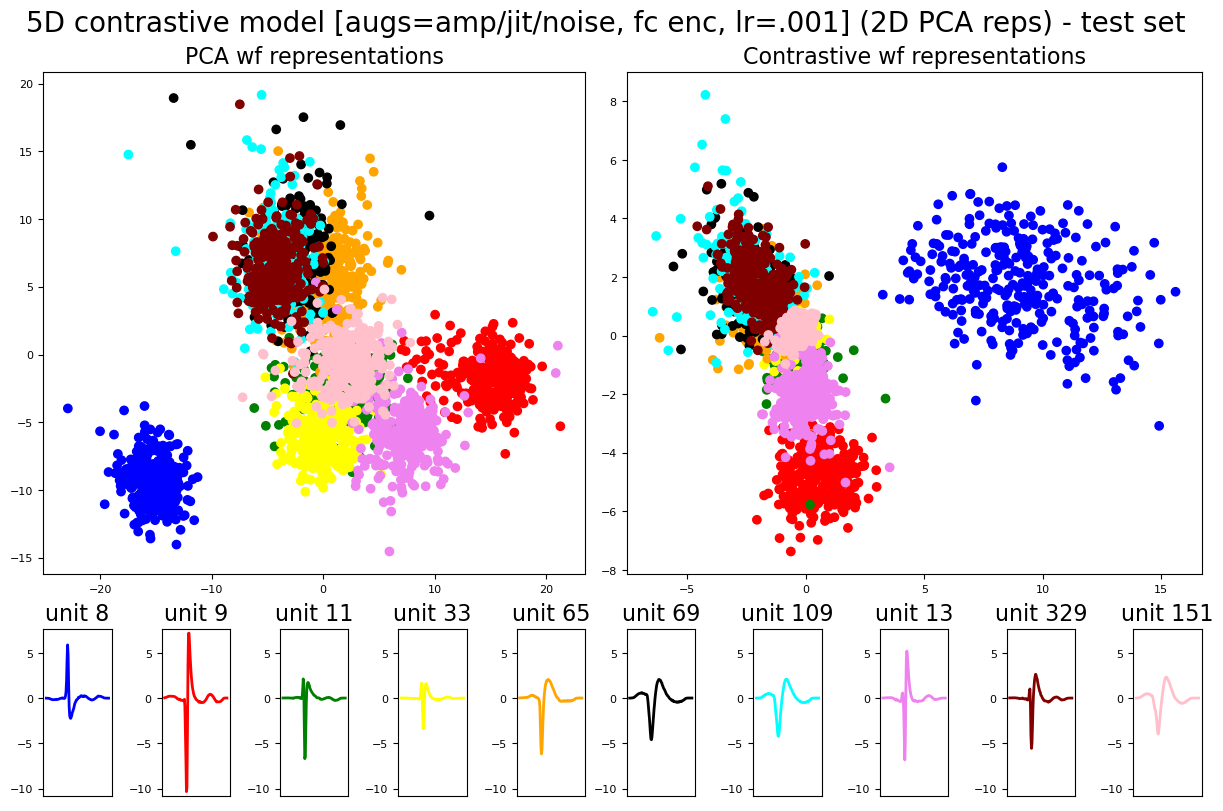

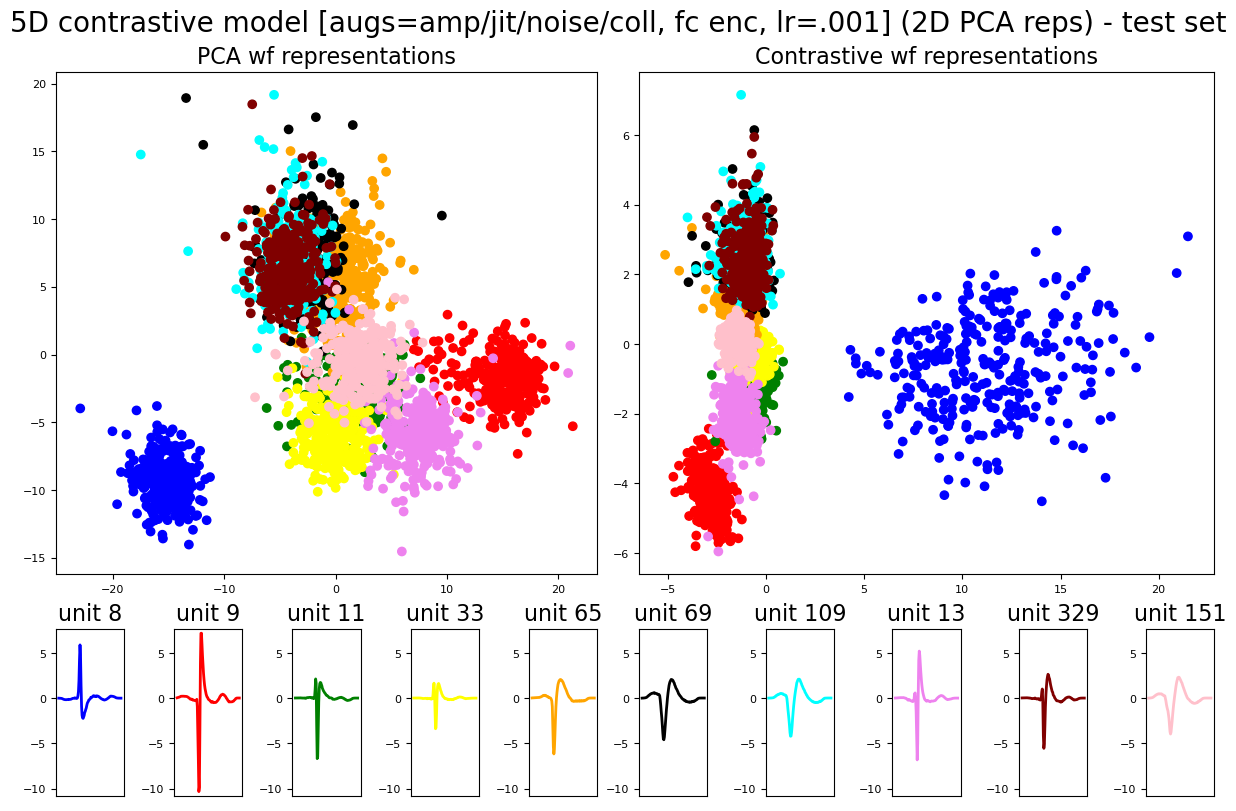

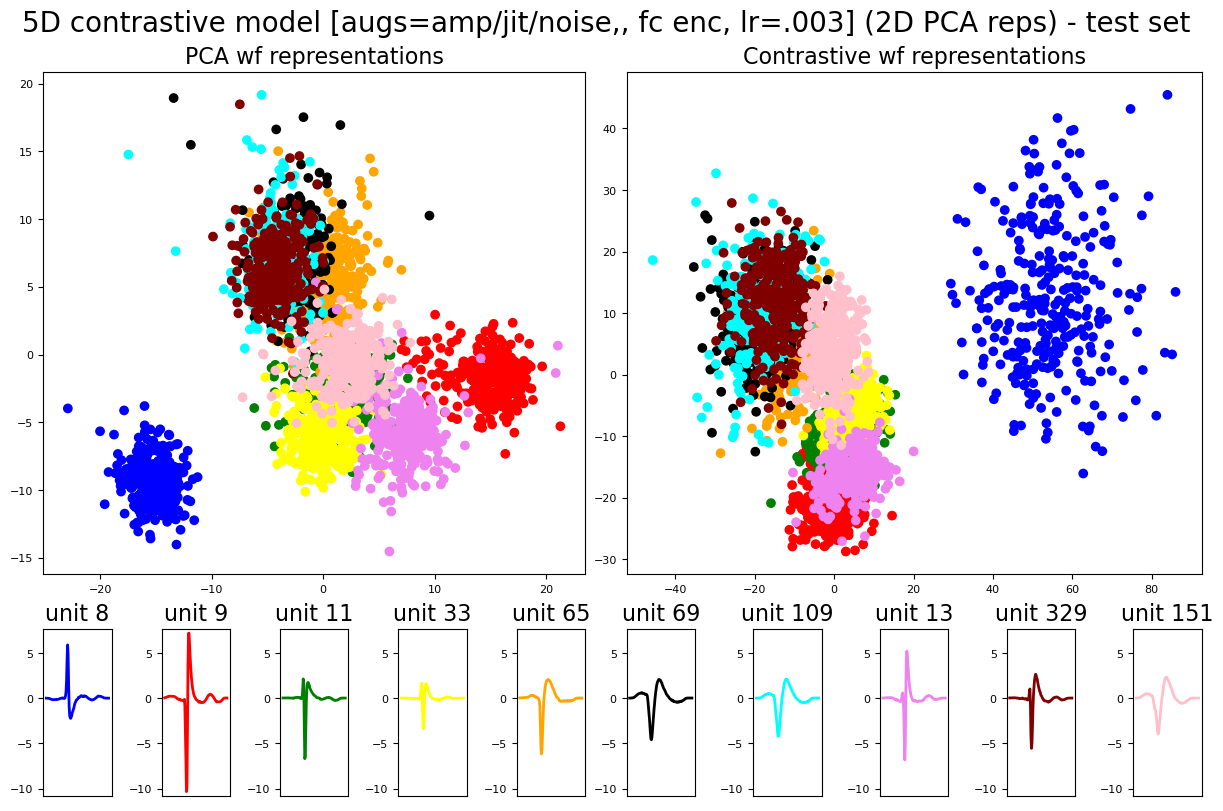

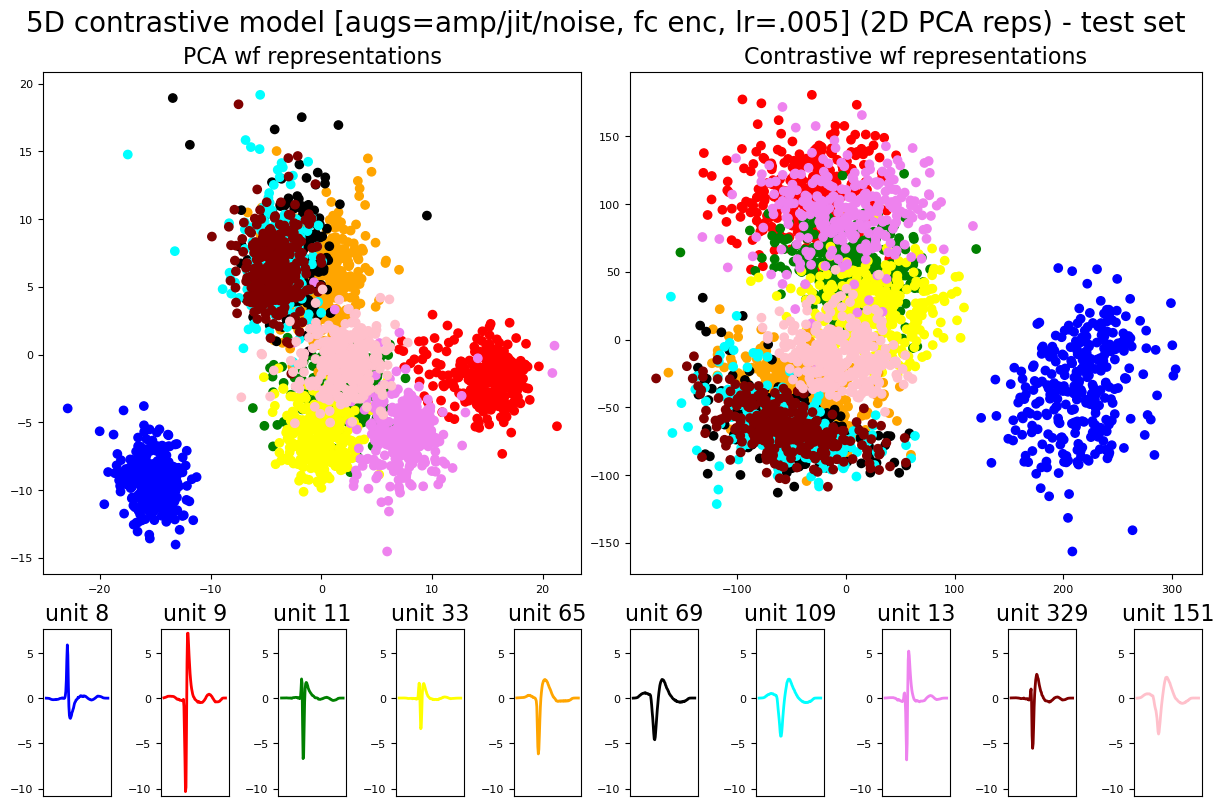

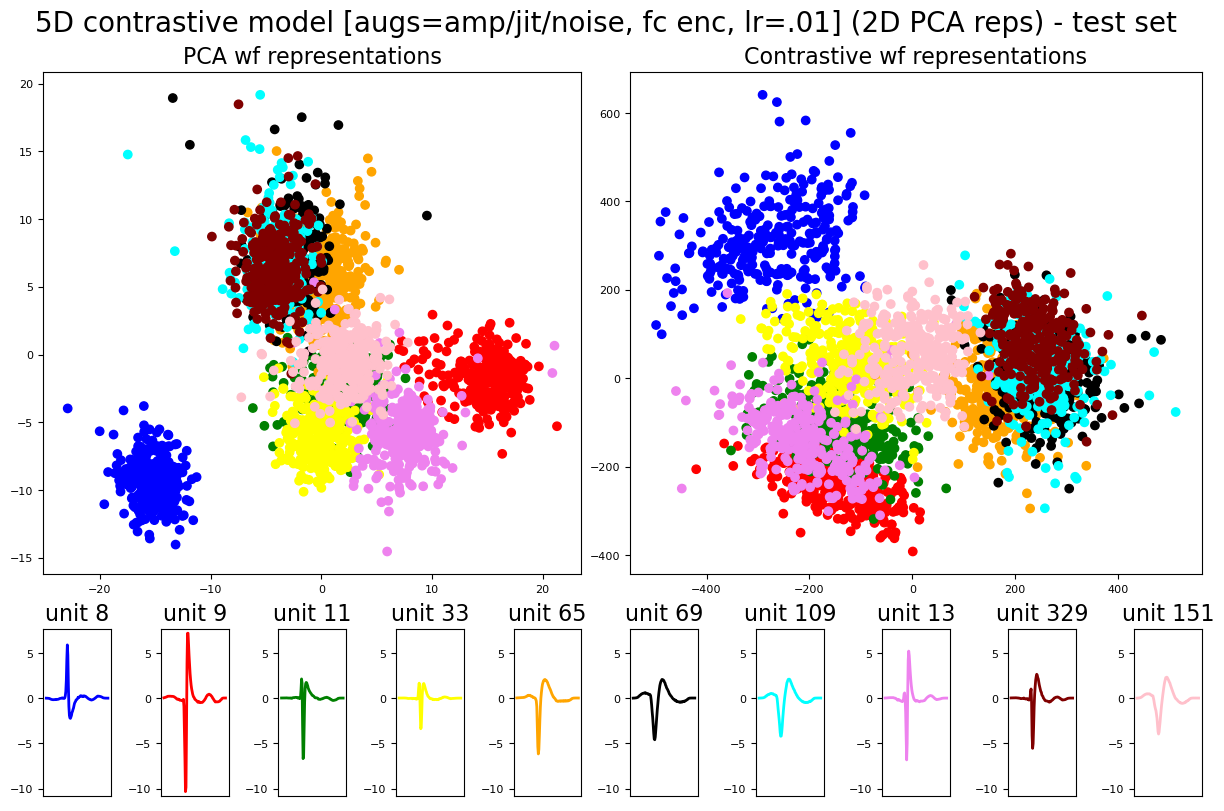

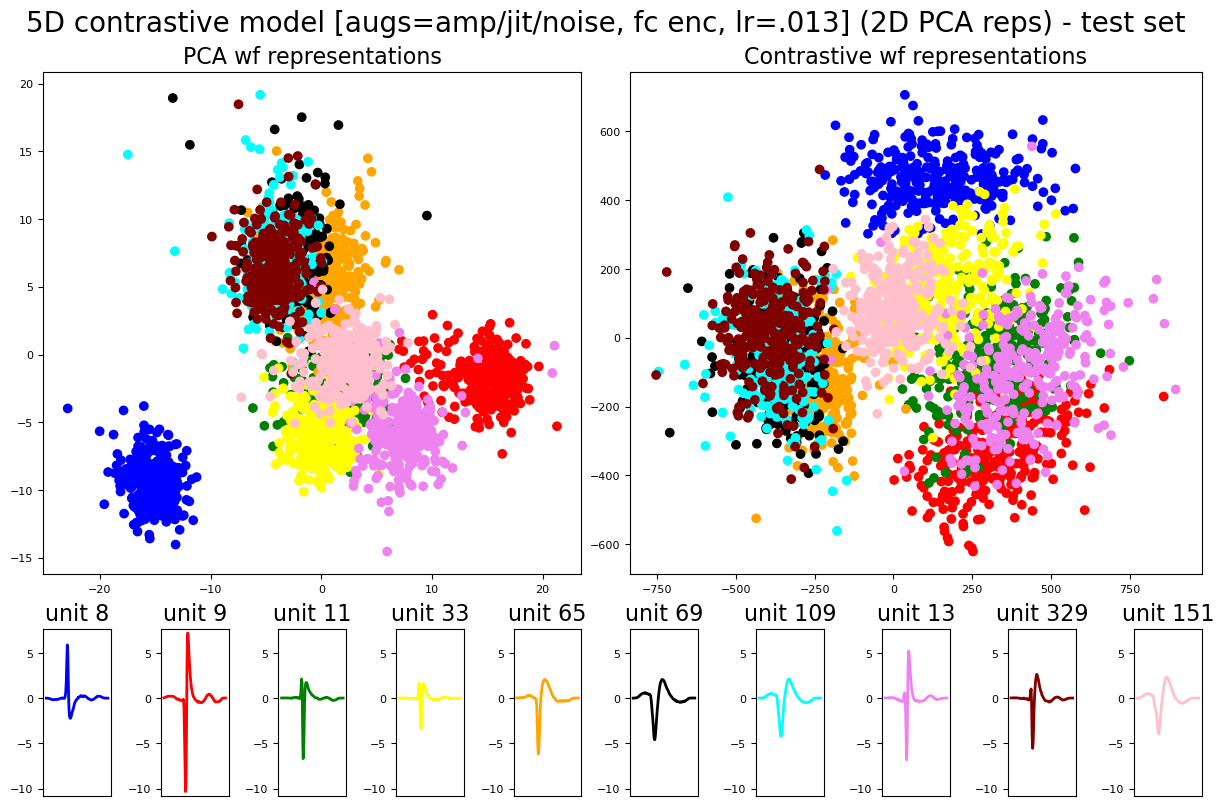

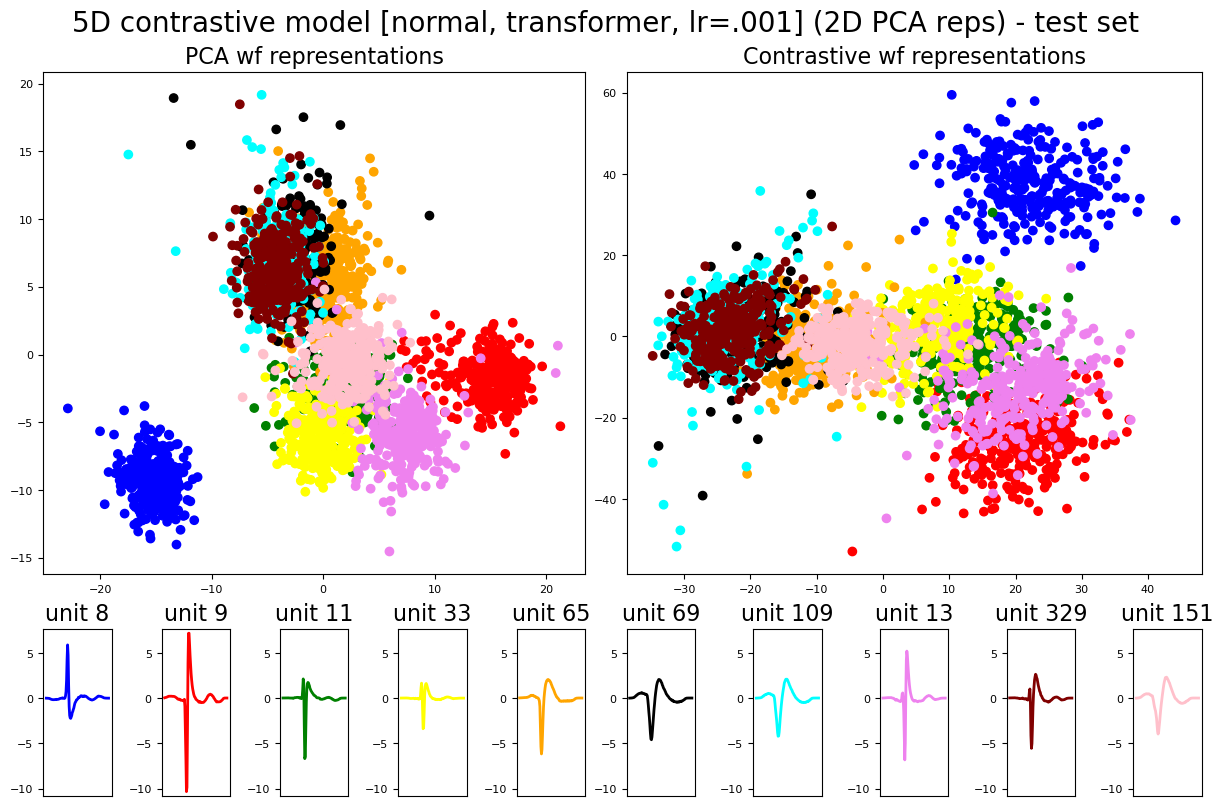

In [214]:
fived_norm_fcenc001_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal/checkpoint_0500.pth.tar'
fived_norm_coll_fcenc001_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal-coll/checkpoint_0400.pth.tar'
fived_norm_fcenc003_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal-lr003/checkpoint_0500.pth.tar'
fived_norm_fcenc005_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal-lr005/checkpoint_0500.pth.tar'
fived_norm_fcenc01_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal-lr01/checkpoint_0500.pth.tar'
fived_norm_fcenc013_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/fcenc-5d5d-normal-lr013/checkpoint_0500.pth.tar'
fived_norm_attenc_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/attenc-5d5d-normal-lr001/checkpoint_0300.pth.tar'


contr_reps_train_5d_n001, contr_reps_test_5d_n001, contr_reps_test_5d_pca_n001, pca_train_5d, pca_test_5d = get_ckpt_results(fived_norm_fcenc001_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise, fc enc, lr=.001] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc')
contr_reps_train_5d_nc001, contr_reps_test_5d_nc001, contr_reps_test_5d_pca_nc001, _, _ = get_ckpt_results(fived_norm_coll_fcenc001_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise/coll, fc enc, lr=.001] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal+coll_fcenc')
contr_reps_train_5d_n003, contr_reps_test_5d_n003, contr_reps_test_5d_pca_n003, _, _ = get_ckpt_results(fived_norm_fcenc003_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise,, fc enc, lr=.003] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc_lr003')
contr_reps_train_5d_n005, contr_reps_test_5d_n005, contr_reps_test_5d_pca_n005, _, _ = get_ckpt_results(fived_norm_fcenc005_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise, fc enc, lr=.005] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc_lr005')
contr_reps_train_5d_n01, contr_reps_test_5d_n01, contr_reps_test_5d_pca_n01, _, _ = get_ckpt_results(fived_norm_fcenc01_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise, fc enc, lr=.01] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc_lr01')
contr_reps_train_5d_n013, contr_reps_test_5d_n013, contr_reps_test_5d_pca_n013, _, _ = get_ckpt_results(fived_norm_fcenc013_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [augs=amp/jit/noise, fc enc, lr=.013] (2D PCA reps) - test set', enc_type='fc_encoder', Lv=[121, 550, 1100, 250], save_name='pca_v_5dcont_normal_fcenc_lr013')
contr_reps_train_5d_attenc_001, contr_reps_test_5d_attenc_001, contr_reps_test_5d_pca_attenc_001, _, _ = get_ckpt_results(fived_norm_attenc_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, '5D contrastive model [normal, transformer, lr=.001] (2D PCA reps) - test set', enc_type='attention_encoder', save_name='pca_v_5dcont_normal_attenc_lr001')


train_reps = [pca_train_5d, 
              contr_reps_train_5d_n001, contr_reps_train_5d_nc001, contr_reps_train_5d_n003, 
              contr_reps_train_5d_n005, contr_reps_train_5d_n01, contr_reps_train_5d_n013,
              contr_reps_train_5d_attenc_001]
test_reps = [pca_test_5d, 
             contr_reps_test_5d_n001, contr_reps_test_5d_nc001, contr_reps_test_5d_n003, 
             contr_reps_test_5d_n005, contr_reps_test_5d_n01, contr_reps_test_5d_n013,
             contr_reps_test_5d_attenc_001]
models = ['PCA 5D',  
          'Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.001)', 'Contrastive 5D (dual view, augs=amp/jit/noise/coll, fc encoder, lr=0.001)',
          'Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.003)', 'Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.005)', 
          'Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.01)', 'Contrastive 5D (dual view, augs=amp/jit/noise, fc encoder, lr=0.013)',
          'Contrastive 5D (augs=amp/jit/noise, transformer, lr=0.001)']


per_class_map = per_class_accs(train_reps, test_reps, models, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, models, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)

2
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
4
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
2
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
2
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
4
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
2
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
4
Using projector; batchnorm False with depth 3; hidden_dim=512
train done
pca test done
300
(3000,)
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training process has finished.
Training proce

wf 8       wf 9  \
PCA 5D                                              100.0  99.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  100.0  99.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  97.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  97.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  97.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  98.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  98.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  100.0  97.000000   

                                                        wf 11      wf 33  \
PCA 5D                                              75.666667  92.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  90.666667  91.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  92.333333  93.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  92.666667  91.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  85.000000  92.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  86.333333  92.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  77.000000  89.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  83.000000  88.333333   

                                                        wf 65      wf 69  \
PCA 5D                                              85.666667  38.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  89.333333  57.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  87.333333  44.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  89.000000  51.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  87.333333  41.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  87.333333  52.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  87.333333  51.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  82.000000  37.000000   

                                                       wf 109      wf 13  \
PCA 5D                                              56.666667  91.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  18.666667  93.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  33.333333  93.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  30.000000  94.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  39.333333  90.000000   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  31.333333  92.666667   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  26.000000  92.333333   
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  53.333333  87.666667   

                                                       wf 329     wf 151  
PCA 5D                                              51.333333  80.666667  
Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  71.000000  89.666667  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  73.666667  92.000000  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  69.333333  91.333333  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  70.666667  85.666667  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  73.666667  88.000000  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  62.333333  82.333333  
Contrastive 5D (augs=a/j/n, transformer, lr=0.0...  56.333333  81.333333

PCA 5D  Contrastive 5D (augs=a/j/n, transformer, lr=0.001)  \
score    76.9                                               80.4    

       Contrastive 5D (augs=a/j/n, transformer, lr=0.0001, fc4)  \
score                                               81.2          

       Contrastive 5D (augs=a/j/n, transformer, lr=0.0001)  \
score                                          81.033333     

       Contrastive 5D (augs=a/j/n, transformer, lr=0.01, sgd)  \
score                                          79.233333        

       Contrastive 5D (augs=a/j/n, transformer, lr=0.01, sgd, fc4)  \
score                                               80.1             

       Contrastive 5D (augs=a/j/n, transformer, lr=0.001, sgd)  \
score                                               77.4         

       Contrastive 5D (augs=a/j/n, transformer, lr=0.001, sgd, fc4)  
score                                          76.466667

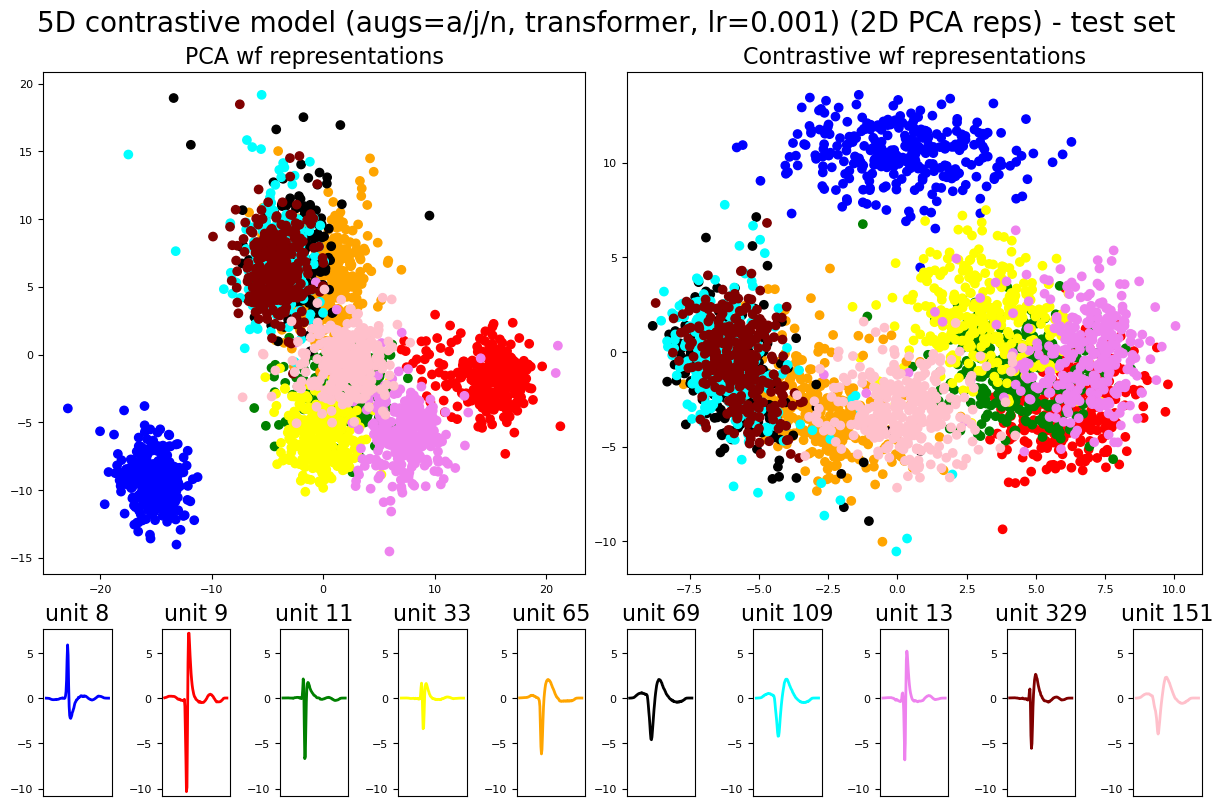

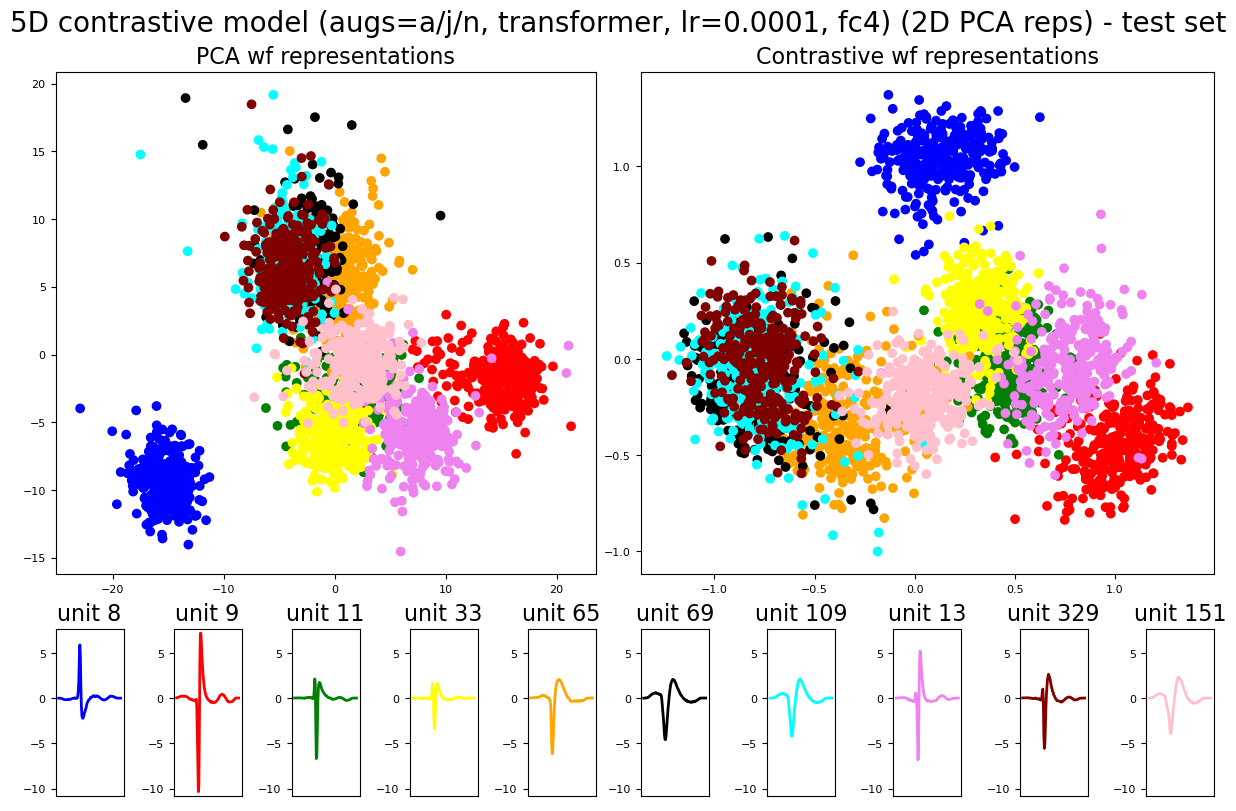

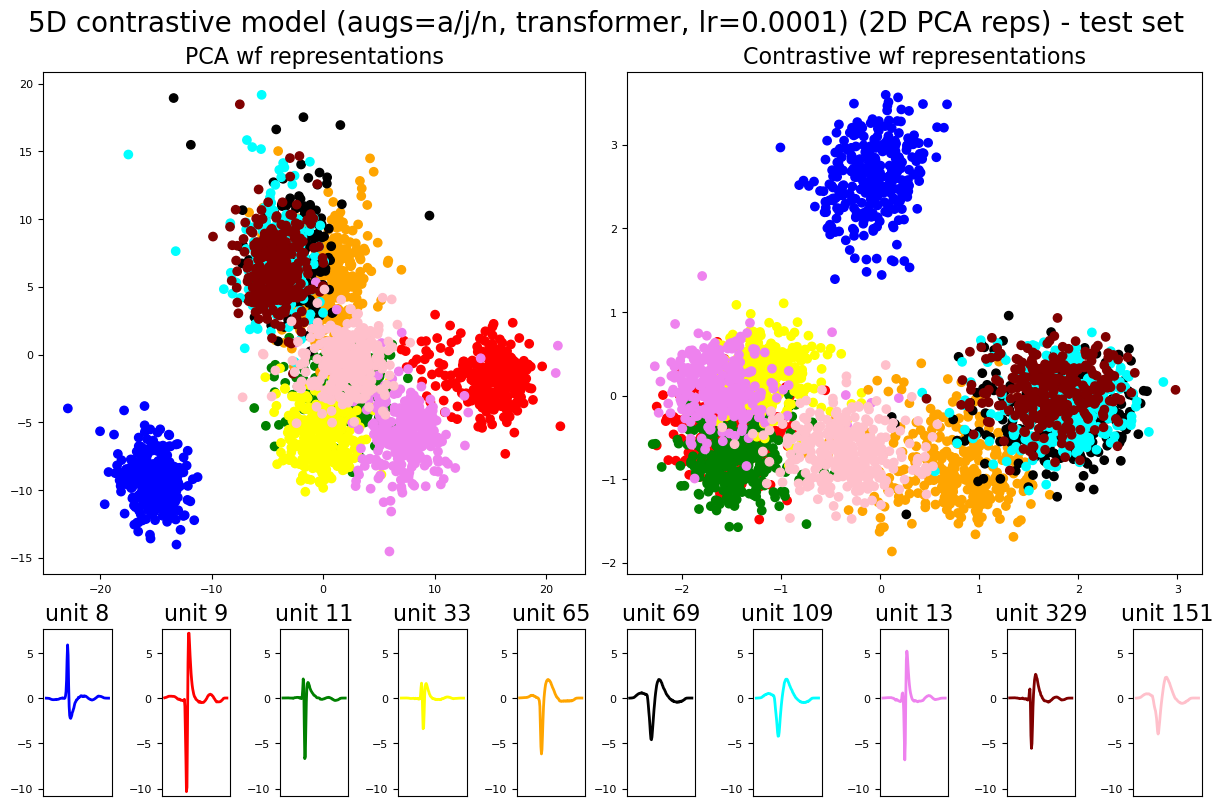

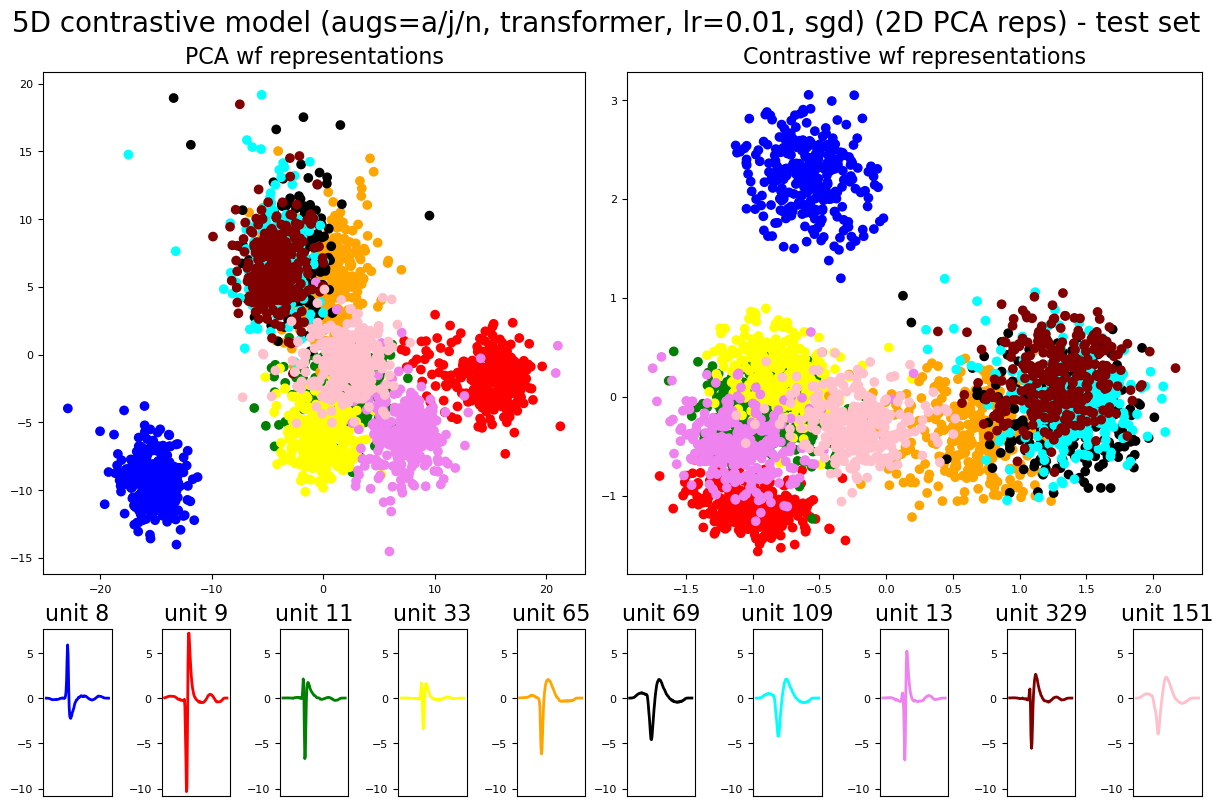

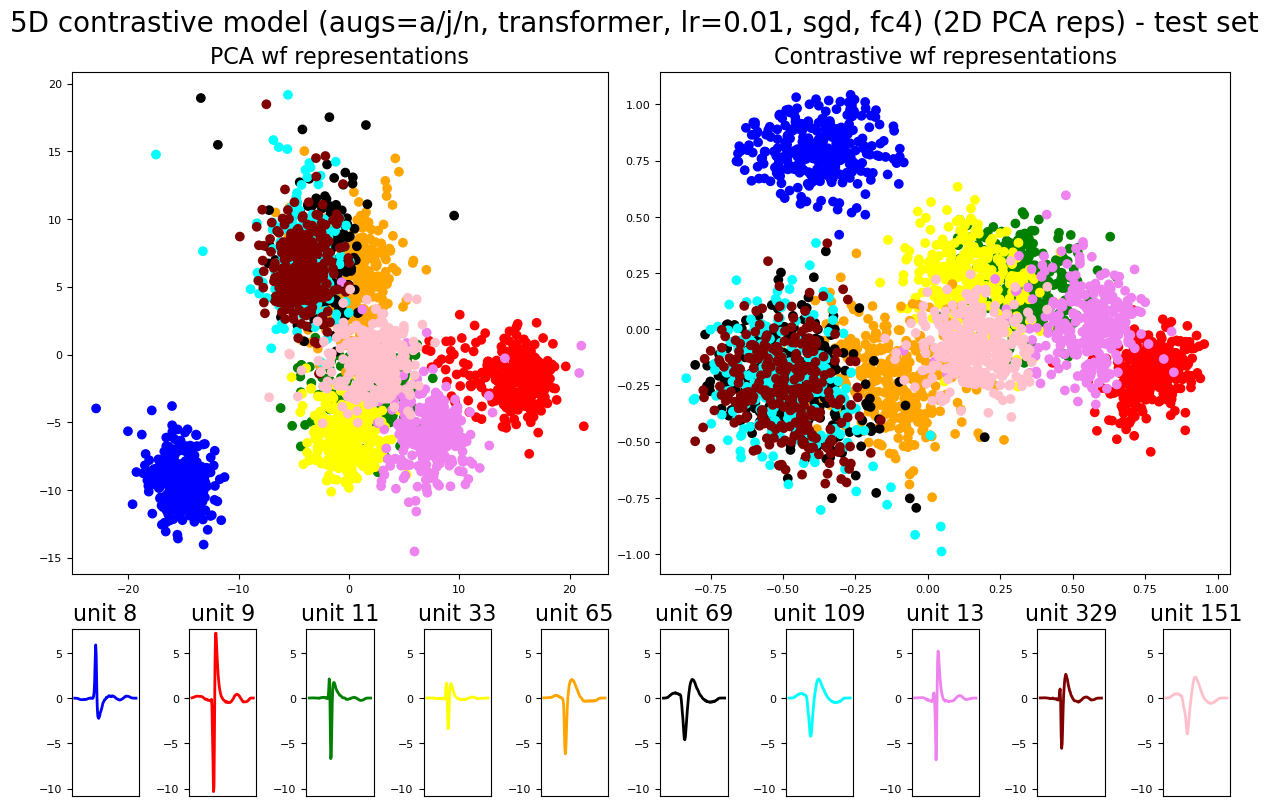

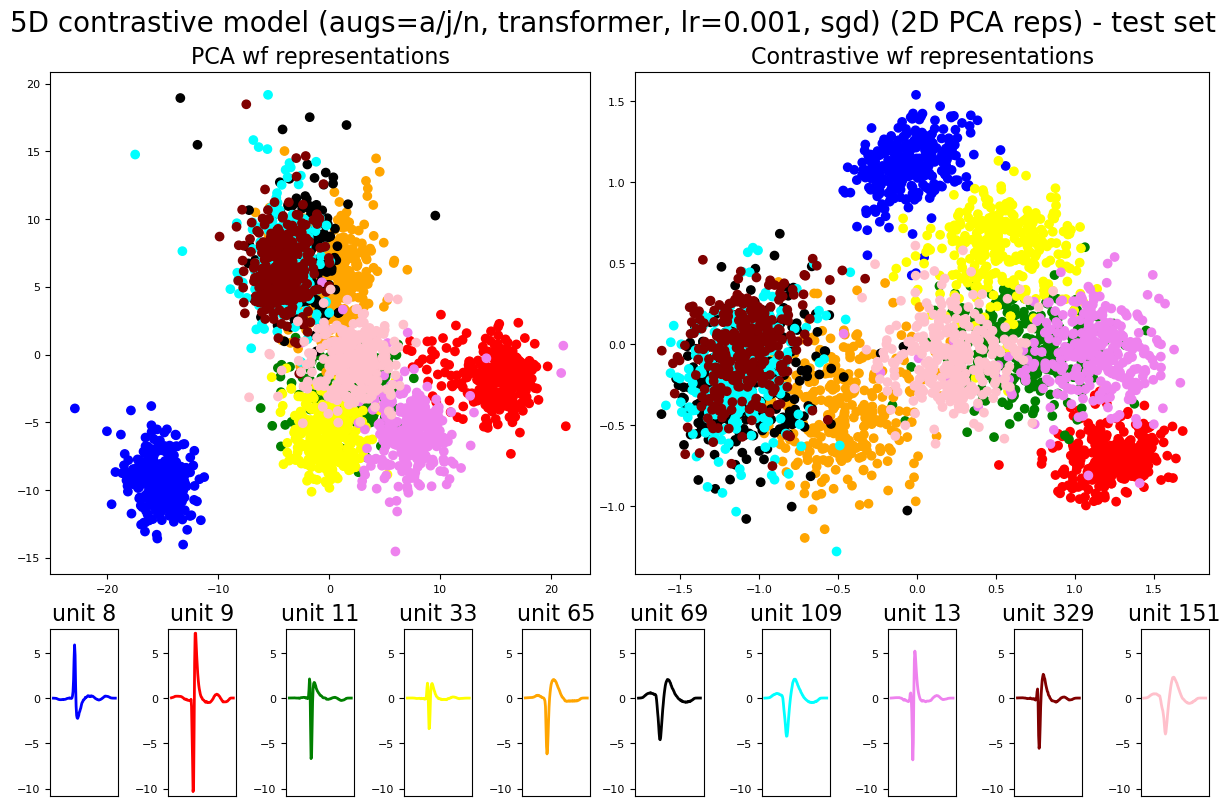

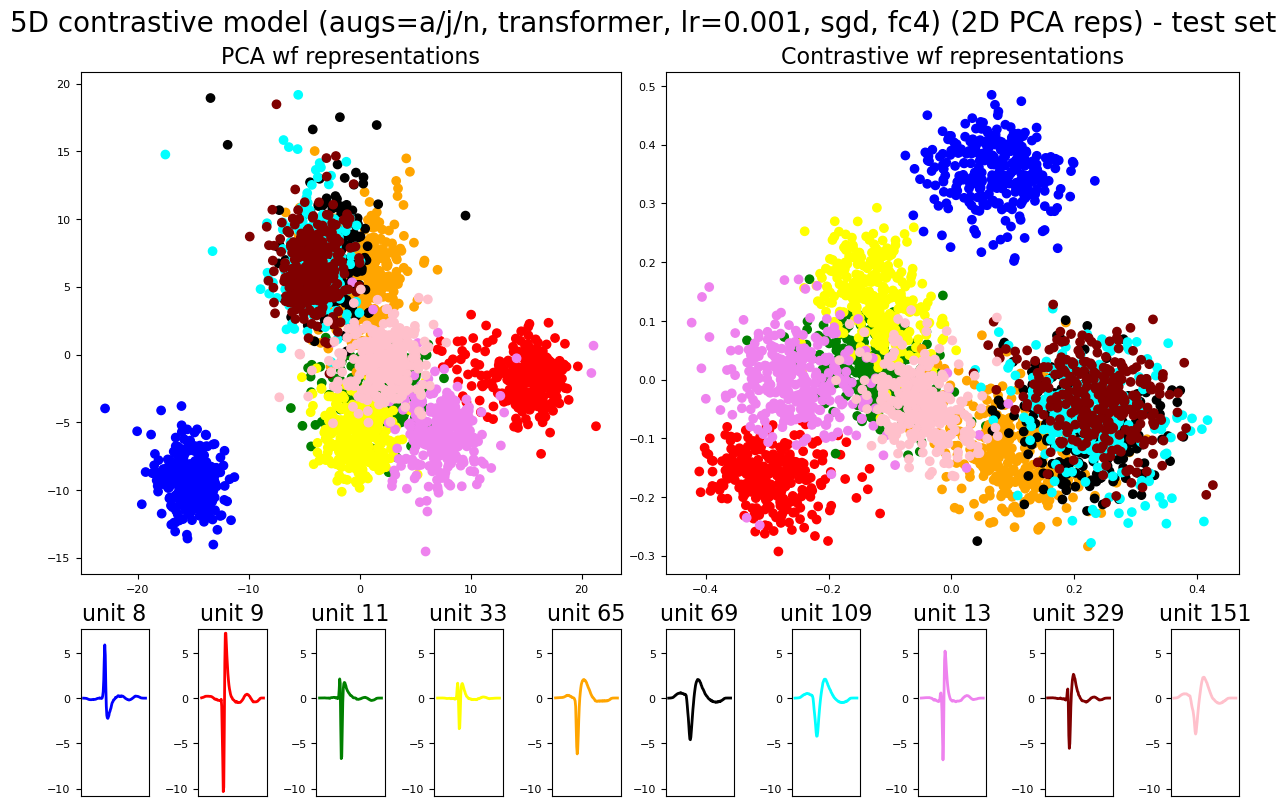

In [238]:
fived_norm_attenc001_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr001/checkpoint_0500.pth.tar'
fived_norm_attenc0001_fc4_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr0001-fc4/checkpoint_0500.pth.tar'
fived_norm_attenc0001_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr0001/checkpoint_0500.pth.tar'
fived_norm_attenc01_sgd_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr01-sgd/checkpoint_0500.pth.tar'
fived_norm_attenc01_sgdfc4_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr01-sgd-fc4/checkpoint_0500.pth.tar'
fived_norm_attenc001_sgd_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr001-sgd/checkpoint_0500.pth.tar'
fived_norm_attenc001_sgdfc4_path = '/Users/ankit/Documents/PaninskiLab/SimCLR-torch/runs/new_augs/spike_att_tb/attenc-5d5d-lr001-sgd-fc4/checkpoint_0500.pth.tar'


contr_reps_train_5d_att001, contr_reps_test_5d_att001, contr_reps_test_5d_pca_att001, pca_train_5d, pca_test_5d = \
    get_ckpt_results(fived_norm_attenc001_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.001) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], \
                     save_name='pca_v_5dcont_normal_attenc_lr001')
contr_reps_train_5d_att0001_fc4, contr_reps_test_5d_att0001_fc4, contr_reps_test_5d_pca_att0001_fc4, _, _ = \
    get_ckpt_results(fived_norm_attenc0001_fc4_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.0001, fc4) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], fc=4, \
                     save_name='pca_v_5dcont_normal_attenc_lr0001fc4')
contr_reps_train_5d_att0001, contr_reps_test_5d_att0001, contr_reps_test_5d_pca_att0001, _, _ = \
    get_ckpt_results(fived_norm_attenc0001_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.0001) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], \
                     save_name='pca_v_5dcont_normal_attenc_lr0001')
contr_reps_train_5d_att01_sgd, contr_reps_test_5d_att01_sgd, contr_reps_test_5d_pca_att01_sgd, _, _ = \
    get_ckpt_results(fived_norm_attenc01_sgd_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.01, sgd) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], \
                     save_name='pca_v_5dcont_normal_attenc_lr01_sgd')
contr_reps_train_5d_att01_sgdfc4, contr_reps_test_5d_att01_sgdfc4, contr_reps_test_5d_pca_att01_sgdfc4, _, _ = \
    get_ckpt_results(fived_norm_attenc01_sgdfc4_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.01, sgd, fc4) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], fc=4, \
                     save_name='pca_v_5dcont_normal_attenc_lr01_sgdfc4')
contr_reps_train_5d_att001_sgd, contr_reps_test_5d_att001_sgd, contr_reps_test_5d_pca_att001_sgd, _, _ = \
    get_ckpt_results(fived_norm_attenc001_sgd_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.001, sgd) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', Lv=[121, 550, 1100, 250], \
                     save_name='pca_v_5dcont_normal_attenc_lr001_sgd')
contr_reps_train_5d_att001_sgdfc4, contr_reps_test_5d_att001_sgdfc4, contr_reps_test_5d_pca_att001_sgdfc4, _, _ = \
    get_ckpt_results(fived_norm_attenc001_sgdfc4_path, 5, dy_wfs_interest, dy_wfs_test, True, dy_wfs, wf_interest_dy, \
                     '5D contrastive model (augs=a/j/n, transformer, lr=0.001, sgd, fc4) (2D PCA reps) - test set', \
                     enc_type='attention_encoder', fc=4, save_name='pca_v_5dcont_normal_attenc_lr001_sgdfc4')


train_reps = [pca_train_5d, 
              contr_reps_train_5d_att001, contr_reps_train_5d_att0001_fc4, contr_reps_train_5d_att0001, 
              contr_reps_train_5d_att01_sgd, contr_reps_train_5d_att01_sgdfc4, contr_reps_train_5d_att001_sgd,
              contr_reps_train_5d_att001_sgdfc4]
test_reps = [pca_test_5d,  
              contr_reps_test_5d_att001, contr_reps_test_5d_att0001_fc4, contr_reps_test_5d_att0001, 
              contr_reps_test_5d_att01_sgd, contr_reps_test_5d_att01_sgdfc4, contr_reps_test_5d_att001_sgd,
              contr_reps_test_5d_att001_sgdfc4]
model_names = ['PCA 5D',  
          'Contrastive 5D (augs=a/j/n, transformer, lr=0.001)', 'Contrastive 5D (augs=a/j/n, transformer, lr=0.0001, fc4)',
          'Contrastive 5D (augs=a/j/n, transformer, lr=0.0001)', 'Contrastive 5D (augs=a/j/n, transformer, lr=0.01, sgd)', 
          'Contrastive 5D (augs=a/j/n, transformer, lr=0.01, sgd, fc4)', 'Contrastive 5D (augs=a/j/n, transformer, lr=0.001, sgd)',
          'Contrastive 5D (augs=a/j/n, transformer, lr=0.001, sgd, fc4)']


per_class_map = per_class_accs(train_reps, test_reps, model_names, 10)
avg_class_map = avg_class_accs(train_reps, test_reps, model_names, 10)

pc_df = pd.DataFrame.from_dict(per_class_map, 'index')
ac_df = pd.DataFrame.from_dict(avg_class_map)

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(pc_df)
    
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(ac_df)